## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

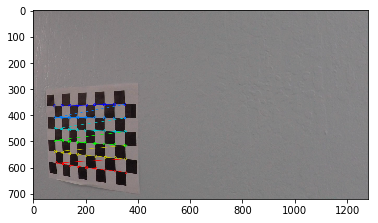

In [1]:
# import matplotlib
# matplotlib.use('Qt5Agg')
import numpy as np
import glob
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython import display
import time
from numpy.linalg import inv
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        plt.imshow(img)
        
        # Show all images
#         display.display(plt.gcf())
#         display.clear_output(wait=True)
#         time.sleep(1.0) # wait one second

## All corners were successfully detected on the chessboard images, we then use these points to calibrate the camera. And the proof of an undistorted image is shown below

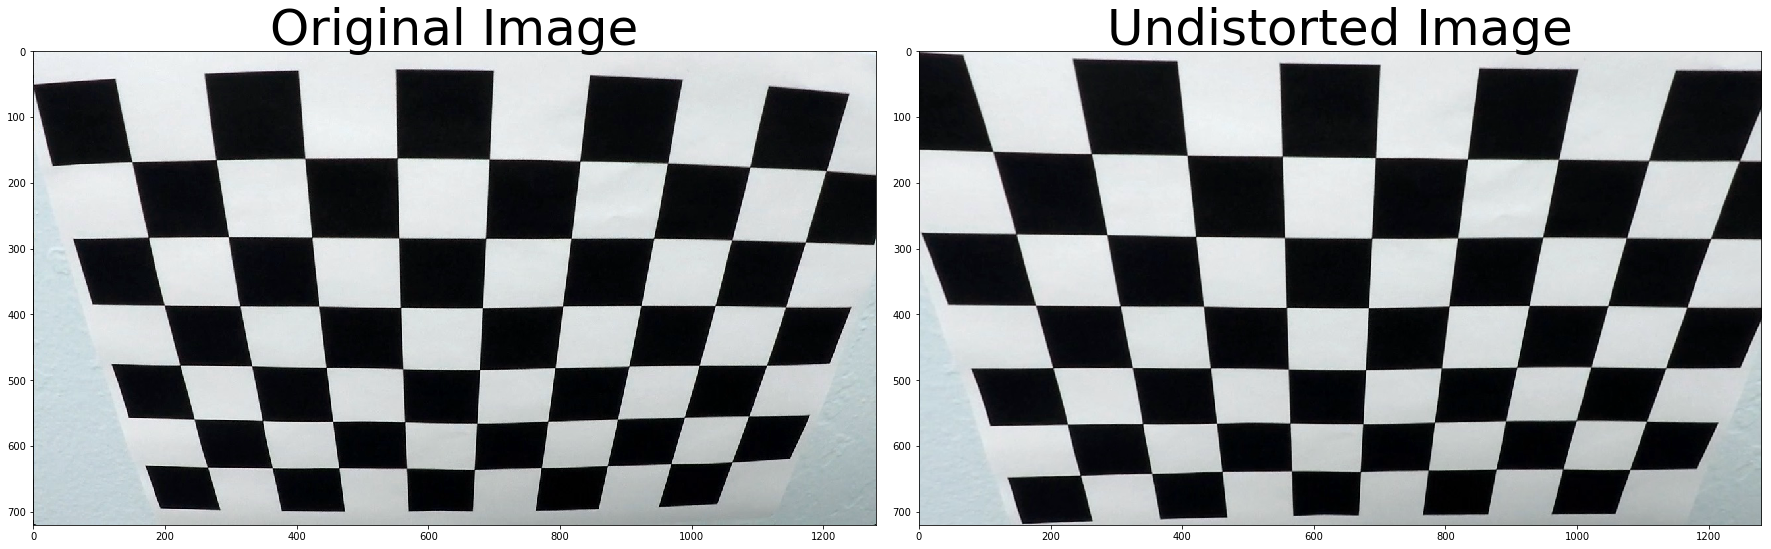

In [2]:
img1 = cv2.imread('../camera_cal/calibration2.jpg')
img_size=(img1.shape[1], img1.shape[0])
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
undist1 = cv2.undistort(img1, mtx, dist, None, mtx)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img1)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undist1)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Confirm the undistortion works as expected

In [3]:
# Define a function that takes an image, number of x and y points, 
# camera matrix and distortion coefficients
def corners_unwarp(img, nx, ny, mtx, dist):
    # Use the OpenCV undistort() function to remove distortion
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # Convert undistorted image to grayscale
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    # Search for corners in the grayscaled image
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    if ret == True:
        # If we found corners, draw them! (just for fun)
        cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
        # Choose offset from image corners to plot detected corners
        # This should be chosen to present the result at the proper aspect ratio
        # My choice of 100 pixels is not exact, but close enough for our purpose here
        offset = 100 # offset for dst points
        # Grab the image shape
        img_size = (gray.shape[1], gray.shape[0])

        # For source points I'm grabbing the outer four detected corners
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        # For destination points, I'm arbitrarily choosing some points to be
        # a nice fit for displaying our warped result 
        # again, not exact, but close enough for our purposes
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])
        # Given src and dst points, calculate the perspective transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
        # Warp the image using OpenCV warpPerspective()
        warped = cv2.warpPerspective(undist, M, img_size)

    # Return the resulting image and matrix
    return warped, M

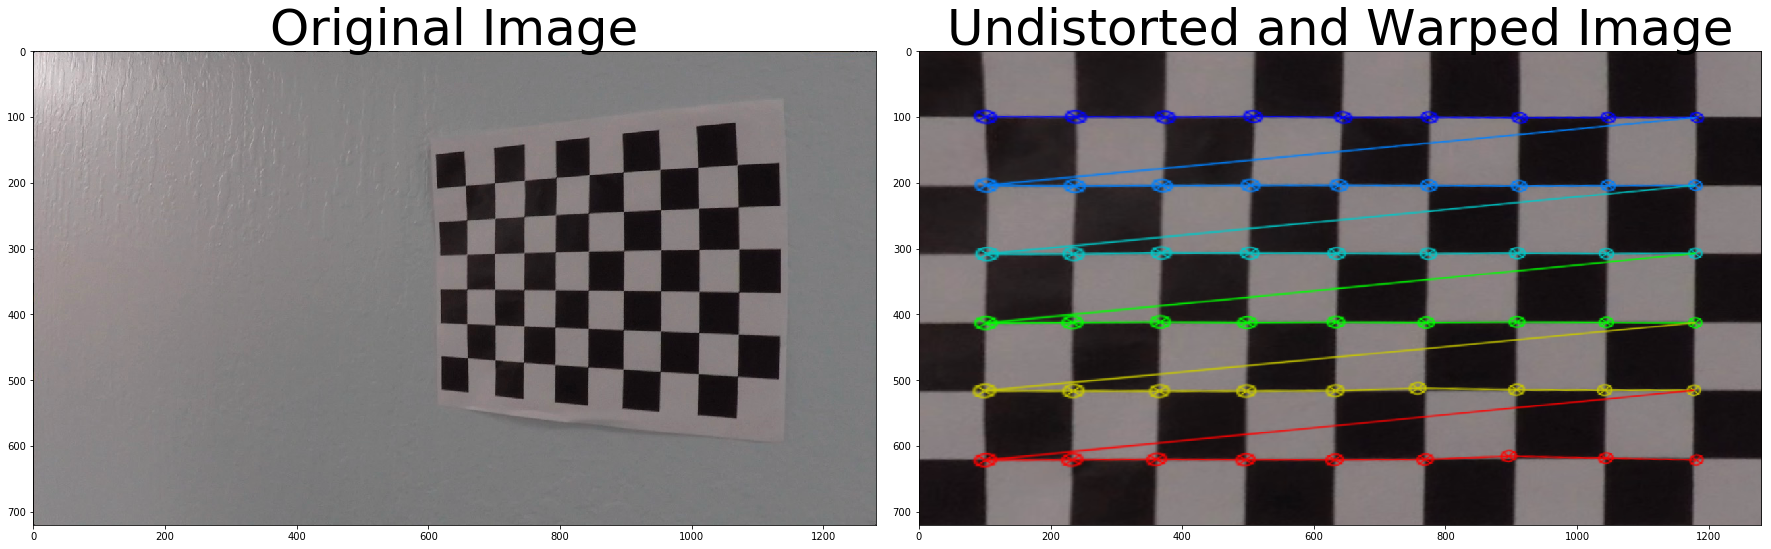

In [4]:
nx = 9
ny = 6
img = cv2.imread('../camera_cal/calibration12.jpg')
top_down, perspective_M = corners_unwarp(img, nx, ny, mtx, dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## We then apply the calibration and undistort the car camera images, and transform perspective

In [5]:
def pipeline (image):
    x=image.shape[1]
    y=image.shape[0]
    
    # window settings
    window_width = 50 
    window_height = 80 # Break image into 9 vertical layers since image height is 720
    margin = 100 # How much to slide left and right for searching
    
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(20, 100))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=3, thresh=(20, 100))
    mag_binary = mag_thresh(image, sobel_kernel=15, mag_thresh=(30, 100))
    dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(.7, 1.3))
    hls_binary = hls_select(image, thresh=(90, 255))
    combined = np.zeros_like(dir_binary)
#     combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1) & (hls_binary == 1))] = 1
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    vertices = np.array([[(0,y*.9),(0.49*x, y/1.6), (0.51*x, y/1.6), (x,y*.9)]], dtype=np.int32)
    masked = region_of_interest(combined, vertices)
    warped, M = unwarp(masked)
#     out_img = np.dstack((warped, warped, warped))*255
    
    histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)
    
    # Floating window
    window_centroids = find_window_centroids(warped, window_width, window_height, margin)
    
    # If we found any window centers
    if len(window_centroids) > 0:

        # Points used to draw all the left and right windows
        l_points = np.zeros_like(warped)
        r_points = np.zeros_like(warped)

        # Go through each level and draw the windows 	
        for level in range(0,len(window_centroids)):
            # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
            r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
            # Add graphic points from window mask here to total pixels found 
            l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
            r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

        # Draw the results
        template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
        zero_channel = np.zeros_like(template) # create a zero color channel
        template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
        warpage= np.dstack((warped, warped, warped))*255 # making the original road pixels 3 color channels
        output = cv2.addWeighted(np.uint8(warpage), .6, np.uint8(template), 0.5, 0.0) # overlay the orignal road image with window results
 
    # If no window centers found, just display orginal road image
    else:
        output = np.array(cv2.merge((warped,warped,warped)),np.uint8)
    
    lcurvature, rcurvature = find_curature(window_centroids)
    result = plot_curvature(window_centroids, image, warped, M)
    return result

In [6]:
# Define a function that takes an image, gradient orientation,
# and threshold min / max values.
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Convert to HLS
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(s_channel, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Convert to HLS
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(s_channel, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

# Define a function that thresholds the S-channel of HLS
def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

# Mask region of interest
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

# Define a function that takes an image, number of x and y points, 
# camera matrix and distortion coefficients
def unwarp(img):
    nx = 4
    ny = 4
    x = img.shape[1]
    y = img.shape[0]
    # Use the OpenCV undistort() function to remove distortion
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    # Convert undistorted image to grayscale
    # gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    img_size = (gray.shape[1], gray.shape[0])

    # For source points I'm grabbing the outer four detected corners
    src = np.float32([(415,650),(1000, 650), (735, 480), (580, 480)])
    # For destination points, I'm arbitrarily choosing some points to be
    # a nice fit for displaying our warped result 
    # again, not exact, but close enough for our purposes
    dst = np.float32([[300, 700], [1000, 700], [1000, 0], [300, 0]])
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(undist, M, img_size)
    binary_output = np.zeros_like(warped)
    binary_output[warped>0] = 1
    # Return the resulting image and matrix
    return binary_output, M

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(image[int(3*image.shape[0]/4):,:int(image.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(image[int(3*image.shape[0]/4):,int(image.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(image.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(image.shape[0]/window_height)):
	    # convolve the window into the vertical slice of the image
	    image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
	    conv_signal = np.convolve(window, image_layer)
	    # Find the best left centroid by using past left center as a reference
	    # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
	    offset = window_width/2
	    l_min_index = int(max(l_center+offset-margin,0))
	    l_max_index = int(min(l_center+offset+margin,image.shape[1]))
	    l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
	    # Find the best right centroid by using past right center as a reference
	    r_min_index = int(max(r_center+offset-margin,0))
	    r_max_index = int(min(r_center+offset+margin,image.shape[1]))
	    r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
	    # Add what we found for that layer
	    window_centroids.append((l_center,r_center))

    return window_centroids

def find_curature(window_centroids):
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    ploty = np.linspace(0, 719, num=9)
    y_eval = np.max(ploty)
    leftx = np.array([item[0] for item in window_centroids])
    rightx = np.array([item[1] for item in window_centroids])

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    print(left_curverad, 'm', right_curverad, 'm')
    
    return left_curverad, right_curverad
    
def plot_curvature(window_centroids, image, warped, M):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    ploty = np.linspace(0, 719, num=9)# to cover same y-range as image
    quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
    # For each y position generate random x position within +/-50 pix
    # of the line base position in each case (x=200 for left, and x=900 for right)
    leftx = np.array([item[0] for item in window_centroids])
    rightx = np.array([item[1] for item in window_centroids])

    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y

    # Fit a second order polynomial to pixel positions in each fake lane line
    left_fit = np.polyfit(ploty, leftx, 2)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fit = np.polyfit(ploty, rightx, 2)
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

#     # Plot the fitted lines against centroids
#     mark_size = 3
#     plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
#     plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
#     plt.xlim(0, 1280)
#     plt.ylim(0, 720)
#     plt.plot(left_fitx, ploty, color='green', linewidth=3)
#     plt.plot(right_fitx, ploty, color='green', linewidth=3)
#     plt.gca().invert_yaxis() # to visualize as we do the images
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    Minv=inv(M)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    result = cv2.addWeighted(undist, 1, newwarp, .3, 0)
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    y_eval = np.max(ploty)
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    cv2.putText(result,'Radius of Curvature: '+str(int(left_curverad))+'m', (40,80), cv2.FONT_HERSHEY_SIMPLEX, 2, [255,255,255], thickness=3)    
    offset = ((left_fitx[-1]+right_fitx[-1])/2 - 640) * xm_per_pix
    cv2.putText(result,'Vehicle is '+"{:.2f}".format(offset)+'m from the center', (40,150), cv2.FONT_HERSHEY_SIMPLEX, 2, [255,255,255], thickness=3)
    return result

563.524473918 m 7085.14135871 m


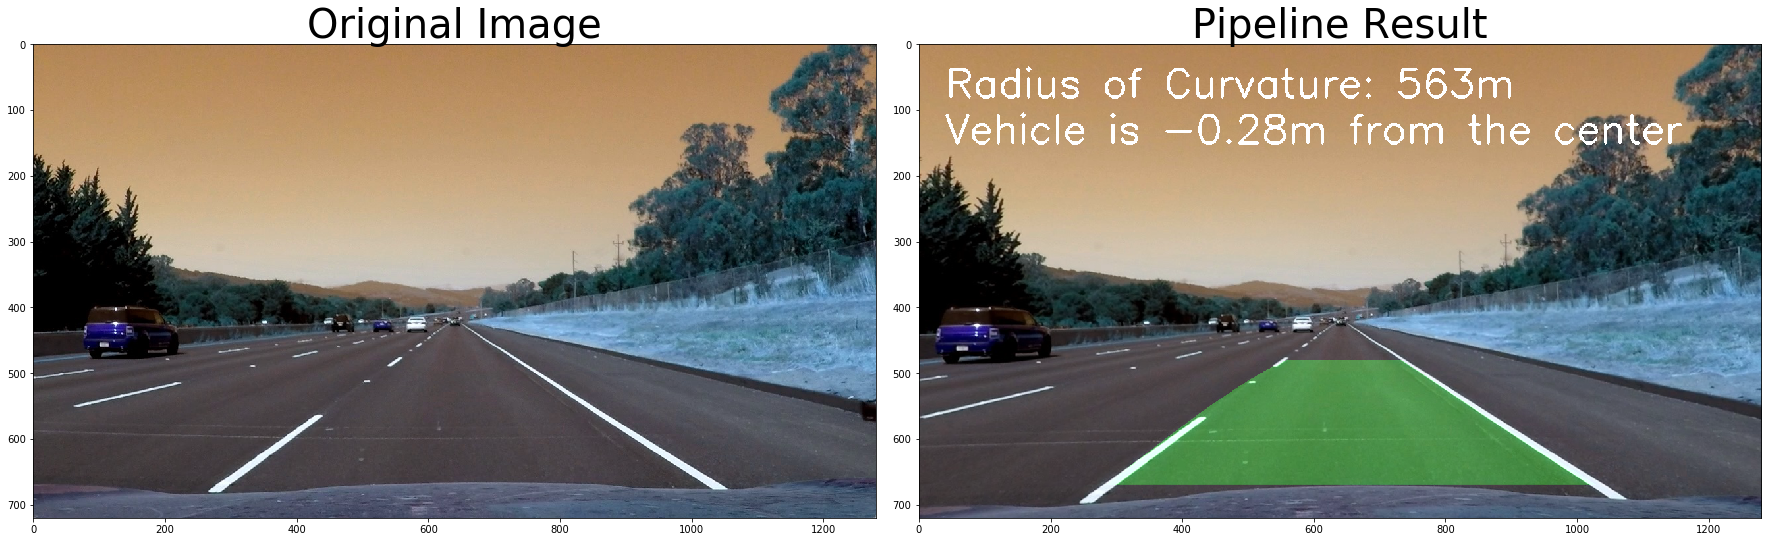

In [7]:
img = cv2.imread('../test_images/straight_lines2.jpg')
# img = cv2.imread('../test_images/test5.jpg')
warped = pipeline(img)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(img)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(warped)
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [8]:
# # Make a list of calibration images
# images = glob.glob('../test_images/test*.jpg')
# for fname in images:
#     img = cv2.imread(fname)
#     warped = pipeline(img)

#     # Plot the result
#     f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
#     f.tight_layout()

#     ax1.imshow(img)
#     ax1.set_title('Original Image', fontsize=40)

#     ax2.imshow(warped)
#     ax2.set_title('Pipeline Result', fontsize=40)
#     plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
#     display.display(plt.gcf())
#     display.clear_output(wait=True)
#     time.sleep(1.0) # wait one second

In [9]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [10]:
output = '../project_video_test.mp4'
## To speed up the testing, use only a subclip of the first 5 seconds
# clip = VideoFileClip("../project_video.mp4").subclip(0,5)
clip = VideoFileClip("../project_video.mp4")
newclip = clip.fl_image(pipeline) #NOTE: this function expects color images!!
%time newclip.write_videofile(output, audio=False, codec='mpeg4')

9430.51143053 m 1111.36994087 m
[MoviePy] >>>> Building video ../project_video_test.mp4
[MoviePy] Writing video ../project_video_test.mp4


  0%|          | 1/1261 [00:00<06:10,  3.40it/s]

9430.51143053 m 1111.36994087 m


  0%|          | 2/1261 [00:00<06:08,  3.42it/s]

1751.97686151 m 2488.05808809 m


  0%|          | 3/1261 [00:00<06:05,  3.44it/s]

5497.41865824 m 202.827391697 m


  0%|          | 4/1261 [00:01<06:08,  3.41it/s]

36054.3724062 m 5922.90129465 m


  0%|          | 5/1261 [00:01<06:06,  3.42it/s]

6253.99189875 m 666.564641301 m


  0%|          | 6/1261 [00:01<06:04,  3.44it/s]

1367.43561727 m 997.388885849 m


  1%|          | 7/1261 [00:02<06:06,  3.42it/s]

5172.9160913 m 444.719479503 m


  1%|          | 8/1261 [00:02<06:03,  3.44it/s]

4198.74681073 m 1751.61797096 m


  1%|          | 9/1261 [00:02<06:01,  3.47it/s]

3296.16729185 m 2602.45610718 m


  1%|          | 10/1261 [00:02<06:00,  3.47it/s]

1349.33126813 m 4317.51626172 m


  1%|          | 11/1261 [00:03<05:58,  3.49it/s]

1782.46407047 m 1.94115080817e+16 m


  1%|          | 12/1261 [00:03<05:57,  3.49it/s]

1806.31706868 m 4540.43234865 m


  1%|          | 13/1261 [00:03<06:00,  3.47it/s]

12138.9931794 m 845.121446434 m


  1%|          | 14/1261 [00:04<06:02,  3.44it/s]

15718.1988864 m 583.972956941 m


  1%|          | 15/1261 [00:04<06:00,  3.46it/s]

2385.76918839 m 2167.93154046 m


  1%|▏         | 16/1261 [00:04<06:01,  3.44it/s]

1916.29441172 m 2597.76920427 m


  1%|▏         | 17/1261 [00:04<05:58,  3.47it/s]

1130.98293485 m 469.901284548 m


  1%|▏         | 18/1261 [00:05<05:58,  3.46it/s]

1458.72685348 m 760.411884385 m


  2%|▏         | 19/1261 [00:05<06:00,  3.44it/s]

1785.61239998 m 3.23525134695e+16 m


  2%|▏         | 20/1261 [00:05<05:57,  3.47it/s]

1450.18442948 m 1528.48524042 m


  2%|▏         | 21/1261 [00:06<06:03,  3.41it/s]

4864.73792362 m 2056.62485888 m


  2%|▏         | 22/1261 [00:06<06:07,  3.37it/s]

2007.83339825 m 1124.63433331 m


  2%|▏         | 23/1261 [00:06<06:06,  3.38it/s]

1839.21359035 m 17027.1479153 m


  2%|▏         | 24/1261 [00:06<06:04,  3.40it/s]

3253.37758082 m 5864.90466556 m


  2%|▏         | 25/1261 [00:07<06:04,  3.39it/s]

2409.82684957 m 267.641790847 m


  2%|▏         | 26/1261 [00:07<06:04,  3.39it/s]

2593.15692202 m 763.261035169 m


  2%|▏         | 27/1261 [00:07<05:58,  3.44it/s]

2163.44162154 m 10573.8136674 m


  2%|▏         | 28/1261 [00:08<05:59,  3.43it/s]

3522.75674674 m 2513.63076318 m


  2%|▏         | 29/1261 [00:08<05:56,  3.46it/s]

24520.8681582 m 927.178840923 m


  2%|▏         | 30/1261 [00:08<05:56,  3.46it/s]

2933.94629454 m 455.968290151 m


  2%|▏         | 31/1261 [00:09<05:57,  3.44it/s]

2322.72980601 m 646.265377982 m


  3%|▎         | 32/1261 [00:09<05:56,  3.45it/s]

1701.11390908 m 3.23525134695e+16 m


  3%|▎         | 33/1261 [00:09<05:53,  3.47it/s]

1378.26227677 m 185.959013121 m


  3%|▎         | 34/1261 [00:09<05:51,  3.49it/s]

1107.22884441 m 1511.37687295 m


  3%|▎         | 35/1261 [00:10<05:48,  3.51it/s]

1798.33185119 m 7662.21343558 m


  3%|▎         | 36/1261 [00:10<05:44,  3.55it/s]

1463.68502237 m 2.11964743421e+16 m


  3%|▎         | 37/1261 [00:10<05:45,  3.54it/s]

1584.60773392 m 354.430620868 m


  3%|▎         | 38/1261 [00:10<05:42,  3.57it/s]

3020.07992737 m 675.902891804 m


  3%|▎         | 39/1261 [00:11<05:42,  3.56it/s]

10568.6151159 m 1986.02015479 m


  3%|▎         | 40/1261 [00:11<05:47,  3.52it/s]

8013.01811202 m 1959.9867707 m


  3%|▎         | 41/1261 [00:11<05:43,  3.55it/s]

26649.5282406 m 1679.47321009 m


  3%|▎         | 42/1261 [00:12<05:43,  3.55it/s]

1990.77007443 m 511.440875528 m


  3%|▎         | 43/1261 [00:12<05:49,  3.49it/s]

5173.22797717 m 593.102389019 m


  3%|▎         | 44/1261 [00:12<05:46,  3.52it/s]

37149.367975 m 359.284836629 m


  4%|▎         | 45/1261 [00:12<05:42,  3.55it/s]

4442.31042261 m 536.029448235 m


  4%|▎         | 46/1261 [00:13<05:43,  3.53it/s]

21508.4494067 m 1363.87979433 m


  4%|▎         | 47/1261 [00:13<05:44,  3.52it/s]

2044.09639019 m 279.190114402 m


  4%|▍         | 48/1261 [00:13<05:41,  3.55it/s]

1644.31065519 m 1827.89488008 m


  4%|▍         | 49/1261 [00:14<05:42,  3.54it/s]

1762.4533136 m 4394.07710458 m


  4%|▍         | 50/1261 [00:14<05:38,  3.58it/s]

2085.86532165 m 221.134781323 m


  4%|▍         | 51/1261 [00:14<05:37,  3.58it/s]

4332.7843619 m 1522.24915805 m


  4%|▍         | 52/1261 [00:14<05:38,  3.57it/s]

2206.05599921 m 2298.30523312 m


  4%|▍         | 53/1261 [00:15<05:38,  3.57it/s]

2755.87680804 m 11795.5391638 m


  4%|▍         | 54/1261 [00:15<05:38,  3.57it/s]

1765.00186518 m 3868.40481139 m


  4%|▍         | 55/1261 [00:15<05:39,  3.55it/s]

2004.45072031 m 460.518711777 m


  4%|▍         | 56/1261 [00:16<05:40,  3.54it/s]

2812.81010511 m 1029.15758267 m


  5%|▍         | 57/1261 [00:16<05:38,  3.56it/s]

1210.42411339 m 232.783964172 m


  5%|▍         | 58/1261 [00:16<05:38,  3.56it/s]

1459.22880417 m 1283.74454131 m


  5%|▍         | 59/1261 [00:16<05:36,  3.57it/s]

1279.70216707 m 2077.62430326 m


  5%|▍         | 60/1261 [00:17<05:36,  3.57it/s]

2372.74097673 m 7475.5363816 m


  5%|▍         | 61/1261 [00:17<05:38,  3.55it/s]

2284.28394478 m 507.239131464 m


  5%|▍         | 62/1261 [00:17<05:37,  3.55it/s]

3694.02098213 m 474.273709521 m


  5%|▍         | 63/1261 [00:18<05:35,  3.57it/s]

7087.63199456 m 970.544664456 m


  5%|▌         | 64/1261 [00:18<05:35,  3.56it/s]

4287.79396623 m 2219.49216814 m


  5%|▌         | 65/1261 [00:18<05:34,  3.57it/s]

5152.28922942 m 2268.6267901 m


  5%|▌         | 66/1261 [00:18<05:37,  3.54it/s]

19157.0941453 m 4047.30178937 m


  5%|▌         | 67/1261 [00:19<05:37,  3.53it/s]

4733.90995311 m 454.265701522 m


  5%|▌         | 68/1261 [00:19<05:34,  3.56it/s]

8455.68301892 m 720.635589333 m


  5%|▌         | 69/1261 [00:19<05:34,  3.57it/s]

1822.42849702 m 3.02310371764e+16 m


  6%|▌         | 70/1261 [00:19<05:35,  3.55it/s]

1795.75928308 m 2927.07819055 m


  6%|▌         | 71/1261 [00:20<05:34,  3.56it/s]

1847.07309496 m 5238.19004799 m


  6%|▌         | 72/1261 [00:20<05:34,  3.55it/s]

5173.03970532 m 1480.39045003 m


  6%|▌         | 73/1261 [00:20<05:37,  3.52it/s]

1830.52987087 m 1996.33422197 m


  6%|▌         | 74/1261 [00:21<05:37,  3.52it/s]

1453.47508123 m 1028.3062695 m


  6%|▌         | 75/1261 [00:21<05:34,  3.55it/s]

1240.69865566 m 474.920740928 m


  6%|▌         | 76/1261 [00:21<05:35,  3.53it/s]

1058.93819735 m 1444.98677615 m


  6%|▌         | 77/1261 [00:21<05:31,  3.57it/s]

4020.59012925 m 2509.09382227 m


  6%|▌         | 78/1261 [00:22<05:32,  3.56it/s]

1620.94988848 m 2118.65890735 m


  6%|▋         | 79/1261 [00:22<05:34,  3.53it/s]

1404.07665515 m 1709.71381652 m


  6%|▋         | 80/1261 [00:22<05:32,  3.56it/s]

1922.93155168 m 460.518711777 m


  6%|▋         | 81/1261 [00:23<05:31,  3.55it/s]

2271.78086575 m 746.579631984 m


  7%|▋         | 82/1261 [00:23<05:32,  3.54it/s]

8286.00126355 m 3.54633320723e+16 m


  7%|▋         | 83/1261 [00:23<05:31,  3.55it/s]

45414.7612586 m 185.959013121 m


  7%|▋         | 84/1261 [00:23<05:31,  3.55it/s]

5174.44187354 m 7297.65016393 m


  7%|▋         | 85/1261 [00:24<05:33,  3.53it/s]

2581.98061634 m 455.968290151 m


  7%|▋         | 86/1261 [00:24<05:31,  3.55it/s]

8014.68015311 m 153228.061534 m


  7%|▋         | 87/1261 [00:24<05:29,  3.57it/s]

3493.56553625 m 3472.34195298 m


  7%|▋         | 88/1261 [00:25<05:31,  3.54it/s]

3606.23101671 m 932.705423754 m


  7%|▋         | 89/1261 [00:25<05:28,  3.57it/s]

1830.45413143 m 651.485148975 m


  7%|▋         | 90/1261 [00:25<05:28,  3.56it/s]

1622.09009245 m 2566.39489061 m


  7%|▋         | 91/1261 [00:25<05:29,  3.55it/s]

5497.68563699 m 206.335254848 m


  7%|▋         | 92/1261 [00:26<05:28,  3.56it/s]

5448.98223995 m 5129.86447423 m


  7%|▋         | 93/1261 [00:26<05:26,  3.58it/s]

4410.17337546 m 583.566949695 m


  7%|▋         | 94/1261 [00:26<05:27,  3.56it/s]

4019.74659821 m 2.33429527565e+16 m


  8%|▊         | 95/1261 [00:27<05:26,  3.57it/s]

1756.90759147 m 579.432262358 m


  8%|▊         | 96/1261 [00:27<05:24,  3.59it/s]

1506.60843362 m 13619.1859955 m


  8%|▊         | 97/1261 [00:27<05:28,  3.54it/s]

1259.27745479 m 299.69379741 m


  8%|▊         | 98/1261 [00:27<05:25,  3.57it/s]

1512.28829898 m 2476.23754742 m


  8%|▊         | 99/1261 [00:28<05:27,  3.55it/s]

1946.53879232 m 2441.68694545 m


  8%|▊         | 100/1261 [00:28<05:27,  3.54it/s]

1586.6770692 m 142.298752403 m


  8%|▊         | 101/1261 [00:28<05:28,  3.53it/s]

1413.07053652 m 1866.83109824 m


  8%|▊         | 102/1261 [00:29<05:26,  3.55it/s]

2225.59699842 m 3169.81925036 m


  8%|▊         | 103/1261 [00:29<05:27,  3.54it/s]

1422.91241024 m 2852.22627077 m


  8%|▊         | 104/1261 [00:29<05:26,  3.54it/s]

2825.4085118 m 2326.14051658 m


  8%|▊         | 105/1261 [00:29<05:24,  3.56it/s]

2625.90008034 m 455.968290151 m


  8%|▊         | 106/1261 [00:30<05:27,  3.53it/s]

1817.05780645 m 619.250483912 m


  8%|▊         | 107/1261 [00:30<05:23,  3.56it/s]

1808.93109421 m 334.679447416 m


  9%|▊         | 108/1261 [00:30<05:24,  3.55it/s]

2296.51983766 m 726.609140949 m


  9%|▊         | 109/1261 [00:30<05:25,  3.54it/s]

2665.70997785 m 22291.0877129 m


  9%|▊         | 110/1261 [00:31<05:24,  3.54it/s]

1698.66511928 m 1265.07012931 m


  9%|▉         | 111/1261 [00:31<05:23,  3.55it/s]

2371.9268963 m 612937.919815 m


  9%|▉         | 112/1261 [00:31<05:24,  3.54it/s]

3682.15168945 m 9651.50414193 m


  9%|▉         | 113/1261 [00:32<05:24,  3.53it/s]

1722.53427942 m 407.290200229 m


  9%|▉         | 114/1261 [00:32<05:26,  3.52it/s]

3574.69907848 m 2793.44466156 m


  9%|▉         | 115/1261 [00:32<05:26,  3.51it/s]

3648.9610542 m 5110.74158919 m


  9%|▉         | 116/1261 [00:32<05:23,  3.53it/s]

1719.97859935 m 1032.68373543 m


  9%|▉         | 117/1261 [00:33<05:23,  3.54it/s]

4378.48710855 m 2543.44333809 m


  9%|▉         | 118/1261 [00:33<05:24,  3.52it/s]

1584.55395634 m 365.034970024 m


  9%|▉         | 119/1261 [00:33<05:24,  3.52it/s]

1904.2306433 m 937.165947717 m


 10%|▉         | 120/1261 [00:34<05:23,  3.53it/s]

1523.60115713 m 540.748049007 m


 10%|▉         | 121/1261 [00:34<05:22,  3.53it/s]

1916.08853481 m 4227.3560535 m


 10%|▉         | 122/1261 [00:34<05:20,  3.55it/s]

10478.0085709 m 1721.52711462 m


 10%|▉         | 123/1261 [00:34<05:19,  3.57it/s]

3168.02473097 m 3339.99407436 m


 10%|▉         | 124/1261 [00:35<05:20,  3.55it/s]

2266.49778667 m 2339.36656906 m


 10%|▉         | 125/1261 [00:35<05:18,  3.57it/s]

1650.65876808 m 408.958432728 m


 10%|▉         | 126/1261 [00:35<05:16,  3.59it/s]

1931.30596242 m 1372.3631281 m


 10%|█         | 127/1261 [00:36<05:19,  3.55it/s]

2043.8876416 m 664.166869188 m


 10%|█         | 128/1261 [00:36<05:16,  3.58it/s]

1246.71454628 m 2859.2580149 m


 10%|█         | 129/1261 [00:36<05:17,  3.57it/s]

1785.30901087 m 1974.20516026 m


 10%|█         | 130/1261 [00:36<05:19,  3.54it/s]

2262.52621487 m 545.549634844 m


 10%|█         | 131/1261 [00:37<05:17,  3.56it/s]

9885.8720281 m 752.95578323 m


 10%|█         | 132/1261 [00:37<05:16,  3.56it/s]

3415.2853672 m 251.020997017 m


 11%|█         | 133/1261 [00:37<05:18,  3.55it/s]

1785.1394 m 1768.1927059 m


 11%|█         | 134/1261 [00:38<05:19,  3.53it/s]

2743.26916156 m 13773.1232334 m


 11%|█         | 135/1261 [00:38<05:28,  3.43it/s]

2040.57088558 m 2129.25372605 m


 11%|█         | 136/1261 [00:38<05:30,  3.41it/s]

5729.39009387 m 2968.66587588 m


 11%|█         | 137/1261 [00:38<05:24,  3.46it/s]

4644.56829931 m 9013.48422135 m


 11%|█         | 138/1261 [00:39<05:20,  3.51it/s]

2433.53186572 m 252.359296904 m


 11%|█         | 139/1261 [00:39<05:19,  3.51it/s]

3880.66491429 m 1257.22970616 m


 11%|█         | 140/1261 [00:39<05:17,  3.53it/s]

6774.33835463 m 4274.60147545 m


 11%|█         | 141/1261 [00:40<05:17,  3.52it/s]

2376.82422904 m 2341.10028057 m


 11%|█▏        | 142/1261 [00:40<05:18,  3.52it/s]

3660.50866282 m 2642.42324167 m


 11%|█▏        | 143/1261 [00:40<05:16,  3.53it/s]

2626.0476629 m 465.162084982 m


 11%|█▏        | 144/1261 [00:40<05:14,  3.56it/s]

17026.8246932 m 901.961215028 m


 11%|█▏        | 145/1261 [00:41<05:20,  3.49it/s]

4591.12246964 m 243.291475488 m


 12%|█▏        | 146/1261 [00:41<05:19,  3.49it/s]

13182.4971026 m 16130.6750892 m


 12%|█▏        | 147/1261 [00:41<05:17,  3.51it/s]

2178.39591576 m 1433.59838493 m


 12%|█▏        | 148/1261 [00:42<05:22,  3.45it/s]

1514.40728047 m 3225.82873253 m


 12%|█▏        | 149/1261 [00:42<05:19,  3.48it/s]

3296.30147075 m 441.788043809 m


 12%|█▏        | 150/1261 [00:42<05:16,  3.51it/s]

17514.5932891 m 398.97941373 m


 12%|█▏        | 151/1261 [00:42<05:16,  3.51it/s]

3287.50076971 m 1245.48577325 m


 12%|█▏        | 152/1261 [00:43<05:13,  3.54it/s]

2170.71822379 m 807.823837205 m


 12%|█▏        | 153/1261 [00:43<05:12,  3.54it/s]

11045.2816122 m 4886.21582804 m


 12%|█▏        | 154/1261 [00:43<05:35,  3.29it/s]

1586.9354129 m 207.231979104 m


 12%|█▏        | 155/1261 [00:44<05:44,  3.21it/s]

2349.62156885 m 1520.768824 m


 12%|█▏        | 156/1261 [00:44<05:39,  3.25it/s]

6224.48871322 m 461.997509262 m


 12%|█▏        | 157/1261 [00:44<05:34,  3.30it/s]

2884.26986521 m 2.71190186435e+16 m


 13%|█▎        | 158/1261 [00:45<05:28,  3.36it/s]

4363.77550862 m 1349.58794674 m


 13%|█▎        | 159/1261 [00:45<05:24,  3.40it/s]

1590.97305953 m 13772.5063174 m


 13%|█▎        | 160/1261 [00:45<05:25,  3.38it/s]

4228.307516 m 29192.3382068 m


 13%|█▎        | 161/1261 [00:45<05:27,  3.36it/s]

13775.4113692 m 4733.58749698 m


 13%|█▎        | 162/1261 [00:46<05:30,  3.33it/s]

3020.63879224 m 2947.22555566 m


 13%|█▎        | 163/1261 [00:46<05:26,  3.36it/s]

2061.46752362 m 252.223775695 m


 13%|█▎        | 164/1261 [00:46<05:20,  3.42it/s]

2064.87765312 m 1755.08795443 m


 13%|█▎        | 165/1261 [00:47<05:19,  3.43it/s]

1593.11683394 m 14956.7799157 m


 13%|█▎        | 166/1261 [00:47<05:39,  3.22it/s]

1423.15565547 m 213.296734849 m


 13%|█▎        | 167/1261 [00:47<05:49,  3.13it/s]

1421.53411541 m 2619.64588265 m


 13%|█▎        | 168/1261 [00:48<05:48,  3.14it/s]

1382.95346271 m 469.901284548 m


 13%|█▎        | 169/1261 [00:48<05:40,  3.21it/s]

1346.68722849 m 348.920992353 m


 13%|█▎        | 170/1261 [00:48<05:34,  3.26it/s]

1100.58637506 m 2.36422213815e+16 m


 14%|█▎        | 171/1261 [00:48<05:27,  3.32it/s]

1090.81885008 m 102153.131279 m


 14%|█▎        | 172/1261 [00:49<05:23,  3.37it/s]

1098.61369045 m 3492.1772056 m


 14%|█▎        | 173/1261 [00:49<05:26,  3.33it/s]

1100.61245271 m 13472.3440945 m


 14%|█▍        | 174/1261 [00:49<05:25,  3.34it/s]

1838.96098278 m 2.88139573088e+16 m


 14%|█▍        | 175/1261 [00:50<05:23,  3.36it/s]

1718.21868623 m 271.579763379 m


 14%|█▍        | 176/1261 [00:50<05:11,  3.48it/s]

1601.4202351 m 1414.99511983 m


 14%|█▍        | 177/1261 [00:50<05:17,  3.41it/s]

2648.77669954 m 3845.66200049 m


 14%|█▍        | 178/1261 [00:51<05:27,  3.31it/s]

1400.66540391 m 2962.54874961 m


 14%|█▍        | 179/1261 [00:51<05:27,  3.30it/s]

3534.51854655 m 1665.58451837 m


 14%|█▍        | 180/1261 [00:51<05:28,  3.29it/s]

2226.37118907 m 752.449720802 m


 14%|█▍        | 181/1261 [00:51<05:19,  3.38it/s]

5499.03635978 m 635.91556519 m


 14%|█▍        | 182/1261 [00:52<05:30,  3.26it/s]

6193.03410169 m 1.77316660362e+16 m


 15%|█▍        | 183/1261 [00:52<05:30,  3.26it/s]

3192.92971696 m 2177.72454015 m


 15%|█▍        | 184/1261 [00:52<05:27,  3.29it/s]

2898.71126446 m 53300.7539182 m


 15%|█▍        | 185/1261 [00:53<05:19,  3.37it/s]

21890.3706331 m 21894.1955278 m


 15%|█▍        | 186/1261 [00:53<05:14,  3.42it/s]

1693.78759013 m 630.049289012 m


 15%|█▍        | 187/1261 [00:53<05:22,  3.33it/s]

2092.55017376 m 480.182602002 m


 15%|█▍        | 188/1261 [00:54<05:25,  3.29it/s]

1115.09262813 m 698.712301218 m


 15%|█▍        | 189/1261 [00:54<05:30,  3.24it/s]

1212.00990282 m 3695.7411693 m


 15%|█▌        | 190/1261 [00:54<05:30,  3.24it/s]

1821.97578523 m 8234.16680804 m


 15%|█▌        | 191/1261 [00:55<05:32,  3.22it/s]

1279.04609364 m 2296.08328392 m


 15%|█▌        | 192/1261 [00:55<05:33,  3.21it/s]

2818.67600061 m 403.372690611 m


 15%|█▌        | 193/1261 [00:55<05:32,  3.21it/s]

4963.41025689 m 694.891936167 m


 15%|█▌        | 194/1261 [00:55<05:31,  3.22it/s]

6418.94862342 m 2.3051165847e+16 m


 15%|█▌        | 195/1261 [00:56<05:27,  3.25it/s]

7759.60033706 m 13325.2977179 m


 16%|█▌        | 196/1261 [00:56<05:28,  3.25it/s]

11902.0637323 m 2456.83229565 m


 16%|█▌        | 197/1261 [00:56<05:26,  3.26it/s]

2125.80469762 m 10134.2335172 m


 16%|█▌        | 198/1261 [00:57<05:26,  3.26it/s]

1258.43110158 m 2159.21271271 m


 16%|█▌        | 199/1261 [00:57<05:19,  3.33it/s]

3435.21598969 m 3904.41473924 m


 16%|█▌        | 200/1261 [00:57<05:09,  3.42it/s]

5498.90295282 m 663.595066873 m


 16%|█▌        | 201/1261 [00:58<05:11,  3.41it/s]

1563.05207786 m 729.533387961 m


 16%|█▌        | 202/1261 [00:58<05:19,  3.31it/s]

5449.76431661 m 146.711981824 m


 16%|█▌        | 203/1261 [00:58<05:21,  3.29it/s]

2078.8156935 m 209.756535702 m


 16%|█▌        | 204/1261 [00:58<05:09,  3.41it/s]

1585.09251204 m 1891.91125723 m


 16%|█▋        | 205/1261 [00:59<05:19,  3.31it/s]

1671.37339027 m 469.901284548 m


 16%|█▋        | 206/1261 [00:59<05:13,  3.36it/s]

2020.80132639 m 330.638531673 m


 16%|█▋        | 207/1261 [00:59<05:06,  3.44it/s]

1471.01911818 m 565.168808595 m


 16%|█▋        | 208/1261 [01:00<05:02,  3.48it/s]

1607.63878744 m 1758.63496913 m


 17%|█▋        | 209/1261 [01:00<04:54,  3.57it/s]

1830.79634832 m 2449.08662577 m


 17%|█▋        | 210/1261 [01:00<04:51,  3.61it/s]

11145.7355421 m 16794.9473343 m


 17%|█▋        | 211/1261 [01:00<04:51,  3.60it/s]

4541.91802416 m 1123.56958112 m


 17%|█▋        | 212/1261 [01:01<04:49,  3.63it/s]

3341.32258778 m 1127.36352365 m


 17%|█▋        | 213/1261 [01:01<04:45,  3.67it/s]

1855.48094052 m 514.364049377 m


 17%|█▋        | 214/1261 [01:01<04:48,  3.62it/s]

2689.4787896 m 608.374060401 m


 17%|█▋        | 215/1261 [01:01<04:45,  3.67it/s]

3856.1597887 m 2021.57624476 m


 17%|█▋        | 216/1261 [01:02<04:44,  3.67it/s]

2390.84412492 m 2452.32970138 m


 17%|█▋        | 217/1261 [01:02<04:46,  3.64it/s]

4348.27866168 m 469.901284548 m


 17%|█▋        | 218/1261 [01:02<04:43,  3.68it/s]

1987.73677758 m 808.549396232 m


 17%|█▋        | 219/1261 [01:03<04:41,  3.70it/s]

1351.24512931 m 479.989205662 m


 17%|█▋        | 220/1261 [01:03<04:54,  3.53it/s]

1366.41029332 m 662.342814325 m


 18%|█▊        | 221/1261 [01:03<04:57,  3.50it/s]

1164.27184809 m 49037.9794773 m


 18%|█▊        | 222/1261 [01:03<05:02,  3.44it/s]

5308.24276329 m 39554.8851133 m


 18%|█▊        | 223/1261 [01:04<04:58,  3.48it/s]

1394.37182178 m 4197.69401172 m


 18%|█▊        | 224/1261 [01:04<04:54,  3.52it/s]

2560.82072895 m 345.894031563 m


 18%|█▊        | 225/1261 [01:04<04:54,  3.51it/s]

1907.89922908 m 1129.16138863 m


 18%|█▊        | 226/1261 [01:05<04:52,  3.53it/s]

2061.80359123 m 2674.01270635 m


 18%|█▊        | 227/1261 [01:05<04:46,  3.60it/s]

1556.98402889 m 10221.0503343 m


 18%|█▊        | 228/1261 [01:05<04:43,  3.64it/s]

1388.12627841 m 1383.6792437 m


 18%|█▊        | 229/1261 [01:05<04:43,  3.64it/s]

2386.63439467 m 527.930980381 m


 18%|█▊        | 230/1261 [01:06<04:40,  3.68it/s]

1806.85165044 m 618.841736958 m


 18%|█▊        | 231/1261 [01:06<04:38,  3.70it/s]

1297.13027453 m 244.240802251 m


 18%|█▊        | 232/1261 [01:06<04:39,  3.69it/s]

1375.74693398 m 192.68457512 m


 18%|█▊        | 233/1261 [01:06<04:36,  3.72it/s]

1730.51364532 m 1806.39090903 m


 19%|█▊        | 234/1261 [01:07<04:35,  3.73it/s]

4214.44832376 m 4256.6195675 m


 19%|█▊        | 235/1261 [01:07<04:37,  3.70it/s]

8121.38451156 m 12382.4205559 m


 19%|█▊        | 236/1261 [01:07<04:36,  3.71it/s]

1561.14404178 m 422.410802468 m


 19%|█▉        | 237/1261 [01:08<04:35,  3.72it/s]

2027.8112263 m 658.103217081 m


 19%|█▉        | 238/1261 [01:08<04:37,  3.69it/s]

3737.54393494 m 755.936743252 m


 19%|█▉        | 239/1261 [01:08<04:35,  3.71it/s]

3930.90175157 m 2672.78705806 m


 19%|█▉        | 240/1261 [01:08<04:34,  3.72it/s]

2409.76802212 m 841.864838416 m


 19%|█▉        | 241/1261 [01:09<04:38,  3.66it/s]

2934.24189654 m 566.461753227 m


 19%|█▉        | 242/1261 [01:09<04:39,  3.65it/s]

2279.96462743 m 567.378409291 m


 19%|█▉        | 243/1261 [01:09<04:36,  3.69it/s]

2713.06716317 m 2.0720149076e+16 m


 19%|█▉        | 244/1261 [01:09<04:37,  3.67it/s]

24036.1412676 m 1085.06898454 m


 19%|█▉        | 245/1261 [01:10<04:35,  3.68it/s]

3533.6278582 m 35022.0279794 m


 20%|█▉        | 246/1261 [01:10<04:33,  3.70it/s]

1940.67166367 m 1958.09397169 m


 20%|█▉        | 247/1261 [01:10<04:34,  3.69it/s]

1872.59469116 m 5782.29025148 m


 20%|█▉        | 248/1261 [01:11<04:32,  3.72it/s]

1479.70984995 m 407.584729771 m


 20%|█▉        | 249/1261 [01:11<04:31,  3.73it/s]

1635.51540077 m 510.763360194 m


 20%|█▉        | 250/1261 [01:11<04:33,  3.70it/s]

1523.72847851 m 532.404677646 m


 20%|█▉        | 251/1261 [01:11<04:30,  3.73it/s]

3955.11901984 m 3306.37176707 m


 20%|█▉        | 252/1261 [01:12<04:30,  3.74it/s]

9728.72815604 m 208.603193864 m


 20%|██        | 253/1261 [01:12<04:33,  3.69it/s]

3464.03593858 m 724.853189881 m


 20%|██        | 254/1261 [01:12<04:34,  3.67it/s]

11350.7527171 m 804.829091456 m


 20%|██        | 255/1261 [01:12<04:34,  3.67it/s]

28510.482568 m 515.338060457 m


 20%|██        | 256/1261 [01:13<04:37,  3.62it/s]

1847.05757315 m 217.460163643 m


 20%|██        | 257/1261 [01:13<04:35,  3.64it/s]

1540.90114867 m 5755.39453326 m


 20%|██        | 258/1261 [01:13<04:36,  3.63it/s]

941.009038694 m 1176.36638763 m


 21%|██        | 259/1261 [01:14<04:37,  3.61it/s]

1607.45563434 m 1874.20739099 m


 21%|██        | 260/1261 [01:14<04:35,  3.63it/s]

1267.27864247 m 482.020189077 m


 21%|██        | 261/1261 [01:14<04:34,  3.64it/s]

2502.74163869 m 281.494714089 m


 21%|██        | 262/1261 [01:14<04:33,  3.65it/s]

2898.94155153 m 1193.40652115 m


 21%|██        | 263/1261 [01:15<04:31,  3.68it/s]

4771.1656063 m 587.637184785 m


 21%|██        | 264/1261 [01:15<04:29,  3.70it/s]

6591.9411921 m 2166.16653357 m


 21%|██        | 265/1261 [01:15<04:36,  3.61it/s]

4924.24127085 m 3443.4893884 m


 21%|██        | 266/1261 [01:15<04:34,  3.62it/s]

3268.7660961 m 458.481811341 m


 21%|██        | 267/1261 [01:16<04:38,  3.57it/s]

2648.45786219 m 347.273858481 m


 21%|██▏       | 268/1261 [01:16<04:39,  3.56it/s]

3463.45126169 m 646.965626765 m


 21%|██▏       | 269/1261 [01:16<04:38,  3.56it/s]

1396.76382953 m 2193.25055938 m


 21%|██▏       | 270/1261 [01:17<04:36,  3.58it/s]

1444.68357934 m 455.968290151 m


 21%|██▏       | 271/1261 [01:17<04:34,  3.60it/s]

2497.36367446 m 5727.81743137 m


 22%|██▏       | 272/1261 [01:17<04:34,  3.60it/s]

2831.68054678 m 3573.56184803 m


 22%|██▏       | 273/1261 [01:17<04:34,  3.60it/s]

2878.18510834 m 470.279821304 m


 22%|██▏       | 274/1261 [01:18<04:37,  3.56it/s]

7429.73765647 m 1055.74271112 m


 22%|██▏       | 275/1261 [01:18<04:34,  3.59it/s]

2805.68247356 m 7171.5737391 m


 22%|██▏       | 276/1261 [01:18<04:40,  3.51it/s]

1600.94867361 m 1684.0536861 m


 22%|██▏       | 277/1261 [01:19<04:43,  3.47it/s]

1525.33684669 m 1868.5548874 m


 22%|██▏       | 278/1261 [01:19<04:44,  3.46it/s]

2614.41369829 m 430.808790913 m


 22%|██▏       | 279/1261 [01:19<04:47,  3.41it/s]

2237.57763314 m 339.80480007 m


 22%|██▏       | 280/1261 [01:19<04:57,  3.30it/s]

2225.3962112 m 2190.09472633 m


 22%|██▏       | 281/1261 [01:20<04:57,  3.30it/s]

1367.24544974 m 76608.7939897 m


 22%|██▏       | 282/1261 [01:20<04:53,  3.34it/s]

1422.67445493 m 4943.68189752 m


 22%|██▏       | 283/1261 [01:20<04:55,  3.31it/s]

1356.67449779 m 10477.0260973 m


 23%|██▎       | 284/1261 [01:21<05:00,  3.26it/s]

1451.30794049 m 4523.0306896 m


 23%|██▎       | 285/1261 [01:21<04:57,  3.29it/s]

3867.58728668 m 547.138165841 m


 23%|██▎       | 286/1261 [01:21<04:51,  3.34it/s]

2270.726534 m 1785.16348325 m


 23%|██▎       | 287/1261 [01:22<04:44,  3.43it/s]

2385.54189839 m 14423.4370477 m


 23%|██▎       | 288/1261 [01:22<04:40,  3.47it/s]

2502.32961233 m 1709.73530451 m


 23%|██▎       | 289/1261 [01:22<04:39,  3.47it/s]

2047.00185429 m 969.775098704 m


 23%|██▎       | 290/1261 [01:22<04:35,  3.52it/s]

1866.34175789 m 402.229345064 m


 23%|██▎       | 291/1261 [01:23<04:33,  3.54it/s]

15133.6585844 m 314.601922671 m


 23%|██▎       | 292/1261 [01:23<04:36,  3.51it/s]

2404.04044137 m 1530.92821235 m


 23%|██▎       | 293/1261 [01:23<04:33,  3.54it/s]

2213.17696077 m 3026.56099035 m


 23%|██▎       | 294/1261 [01:24<04:31,  3.56it/s]

2423.08665943 m 2370.85077524 m


 23%|██▎       | 295/1261 [01:24<04:32,  3.55it/s]

3012.38735961 m 72102.3455025 m


 23%|██▎       | 296/1261 [01:24<04:30,  3.56it/s]

2064.16827971 m 2106.06260264 m


 24%|██▎       | 297/1261 [01:24<04:28,  3.59it/s]

3795.60929242 m 632.352722656 m


 24%|██▎       | 298/1261 [01:25<04:30,  3.56it/s]

9885.38692387 m 2497.32984694 m


 24%|██▎       | 299/1261 [01:25<04:28,  3.59it/s]

3967.64842578 m 408664.952107 m


 24%|██▍       | 300/1261 [01:25<04:30,  3.55it/s]

10302.1029791 m 816.065964098 m


 24%|██▍       | 301/1261 [01:26<04:34,  3.50it/s]

4865.08174566 m 2257.39315164 m


 24%|██▍       | 302/1261 [01:26<04:33,  3.51it/s]

2357.98857562 m 455.968290151 m


 24%|██▍       | 303/1261 [01:26<04:31,  3.53it/s]

8573.00270418 m 338.558178771 m


 24%|██▍       | 304/1261 [01:26<04:31,  3.53it/s]

7211.44691481 m 545.196479765 m


 24%|██▍       | 305/1261 [01:27<04:27,  3.57it/s]

2193.53361694 m 263.148387134 m


 24%|██▍       | 306/1261 [01:27<04:25,  3.60it/s]

1880.70633608 m 1537.92594379 m


 24%|██▍       | 307/1261 [01:27<04:27,  3.57it/s]

2213.30249372 m 3376.66756586 m


 24%|██▍       | 308/1261 [01:27<04:25,  3.59it/s]

3252.00770168 m 2265.69734905 m


 25%|██▍       | 309/1261 [01:28<04:25,  3.59it/s]

3313.60112079 m 136.174412979 m


 25%|██▍       | 310/1261 [01:28<04:27,  3.56it/s]

3522.96575159 m 1078.83426132 m


 25%|██▍       | 311/1261 [01:28<04:26,  3.56it/s]

15323.4930517 m 6068.97840017 m


 25%|██▍       | 312/1261 [01:29<04:34,  3.46it/s]

2177.81449242 m 208.369744139 m


 25%|██▍       | 313/1261 [01:29<04:43,  3.35it/s]

4183.94312206 m 391.233171985 m


 25%|██▍       | 314/1261 [01:29<04:46,  3.31it/s]

8755.93770369 m 525.816522763 m


 25%|██▍       | 315/1261 [01:30<04:48,  3.28it/s]

3234.76734226 m 301.118322265 m


 25%|██▌       | 316/1261 [01:30<05:11,  3.04it/s]

4983.32310277 m 7297.52580843 m


 25%|██▌       | 317/1261 [01:30<05:01,  3.13it/s]

1889.2693501 m 4155.28807776 m


 25%|██▌       | 318/1261 [01:31<05:18,  2.96it/s]

14421.610025 m 3748.40418603 m


 25%|██▌       | 319/1261 [01:31<05:15,  2.99it/s]

6590.60823826 m 6554.72098428 m


 25%|██▌       | 320/1261 [01:31<04:59,  3.15it/s]

4183.88794437 m 419.661736604 m


 25%|██▌       | 321/1261 [01:32<04:46,  3.28it/s]

5701.62941498 m 29184.7019348 m


 26%|██▌       | 322/1261 [01:32<04:51,  3.22it/s]

15516.5658456 m 1499.78612495 m


 26%|██▌       | 323/1261 [01:32<04:52,  3.21it/s]

6038.69899779 m 2216.50439538 m


 26%|██▌       | 324/1261 [01:32<04:57,  3.14it/s]

2019.86041332 m 202.167452725 m


 26%|██▌       | 325/1261 [01:33<05:06,  3.05it/s]

4045.80374213 m 1096.46852629 m


 26%|██▌       | 326/1261 [01:33<05:11,  3.00it/s]

3260.3384148 m 349.191567226 m


 26%|██▌       | 327/1261 [01:34<05:20,  2.92it/s]

3012.02220999 m 289.237265036 m


 26%|██▌       | 328/1261 [01:34<05:15,  2.96it/s]

2786.1591612 m 514.250637996 m


 26%|██▌       | 329/1261 [01:34<05:14,  2.97it/s]

2313.25015877 m 2.16952149148e+16 m


 26%|██▌       | 330/1261 [01:35<05:12,  2.97it/s]

2006.57837238 m 1075.55103871 m


 26%|██▌       | 331/1261 [01:35<05:12,  2.97it/s]

2375.79376424 m 1471.75109197 m


 26%|██▋       | 332/1261 [01:35<05:09,  3.00it/s]

7908.30932975 m 411.82127168 m


 26%|██▋       | 333/1261 [01:36<05:03,  3.06it/s]

42266.8744702 m 585.3673593 m


 26%|██▋       | 334/1261 [01:36<04:52,  3.17it/s]

3680.92229448 m 635.418965149 m


 27%|██▋       | 335/1261 [01:36<04:48,  3.21it/s]

10566.6421505 m 5238.41630252 m


 27%|██▋       | 336/1261 [01:36<04:59,  3.09it/s]

13323.332752 m 1255.87058133 m


 27%|██▋       | 337/1261 [01:37<05:06,  3.02it/s]

8395.46047498 m 1323.73253182 m


 27%|██▋       | 338/1261 [01:37<05:03,  3.04it/s]

122576.617739 m 451.508059176 m


 27%|██▋       | 339/1261 [01:37<04:58,  3.09it/s]

25536.8440513 m 308.572197626 m


 27%|██▋       | 340/1261 [01:38<04:55,  3.11it/s]

9651.82549642 m 725.867335488 m


 27%|██▋       | 341/1261 [01:38<04:53,  3.13it/s]

2362.04532775 m 1308.02735332 m


 27%|██▋       | 342/1261 [01:38<04:58,  3.07it/s]

2586.16670221 m 455.968290151 m


 27%|██▋       | 343/1261 [01:39<04:46,  3.21it/s]

1686.38576969 m 1585.93493811 m


 27%|██▋       | 344/1261 [01:39<04:37,  3.31it/s]

3795.21576931 m 4.98403585881e+16 m


 27%|██▋       | 345/1261 [01:39<04:28,  3.41it/s]

1906.70511368 m 464.357348409 m


 27%|██▋       | 346/1261 [01:40<04:38,  3.29it/s]

2088.56050196 m 26080.2756266 m


 28%|██▊       | 347/1261 [01:40<04:34,  3.33it/s]

3209.15277157 m 8693.73631552 m


 28%|██▊       | 348/1261 [01:40<04:28,  3.41it/s]

3313.24190198 m 1096.3579079 m


 28%|██▊       | 349/1261 [01:40<04:23,  3.46it/s]

2871.0129914 m 1128.76015497 m


 28%|██▊       | 350/1261 [01:41<04:17,  3.53it/s]

2811.71221178 m 451.508059176 m


 28%|██▊       | 351/1261 [01:41<04:25,  3.42it/s]

4045.65140216 m 309.719361764 m


 28%|██▊       | 352/1261 [01:41<04:36,  3.28it/s]

4241.5963518 m 408.737291295 m


 28%|██▊       | 353/1261 [01:42<04:32,  3.33it/s]

3251.62348564 m 15132.4869663 m


 28%|██▊       | 354/1261 [01:42<04:25,  3.42it/s]

2760.96035733 m 818.809788282 m


 28%|██▊       | 355/1261 [01:42<04:23,  3.43it/s]

8281.95898864 m 4377.64864383 m


 28%|██▊       | 356/1261 [01:42<04:20,  3.48it/s]

4212.44670762 m 818.852808264 m


 28%|██▊       | 357/1261 [01:43<04:16,  3.52it/s]

14252.6383002 m 412.434285298 m


 28%|██▊       | 358/1261 [01:43<04:16,  3.52it/s]

7908.22421894 m 35021.7319551 m


 28%|██▊       | 359/1261 [01:43<04:12,  3.58it/s]

1974.08334673 m 4300.894633 m


 29%|██▊       | 360/1261 [01:44<04:17,  3.50it/s]

1193.93431472 m 1137.0410704 m


 29%|██▊       | 361/1261 [01:44<04:33,  3.29it/s]

4523.27032472 m 1360.47035333 m


 29%|██▊       | 362/1261 [01:44<04:35,  3.26it/s]

2532.71291131 m 447.135366195 m


 29%|██▉       | 363/1261 [01:45<04:30,  3.33it/s]

1721.94267296 m 293.979169636 m


 29%|██▉       | 364/1261 [01:45<04:25,  3.38it/s]

2212.90827581 m 3159.39873922 m


 29%|██▉       | 365/1261 [01:45<04:38,  3.22it/s]

1961.58882221 m 1095.12139111 m


 29%|██▉       | 366/1261 [01:45<04:32,  3.28it/s]

1739.13068383 m 3242.68093127 m


 29%|██▉       | 367/1261 [01:46<04:31,  3.30it/s]

2291.59388759 m 1557.79530891 m


 29%|██▉       | 368/1261 [01:46<04:22,  3.40it/s]

2266.23745126 m 3049.44992802 m


 29%|██▉       | 369/1261 [01:46<04:17,  3.47it/s]

2754.81533878 m 132.961087126 m


 29%|██▉       | 370/1261 [01:47<04:19,  3.43it/s]

4241.68793086 m 1072.69970905 m


 29%|██▉       | 371/1261 [01:47<04:33,  3.25it/s]

15133.5660037 m 7085.40220593 m


 30%|██▉       | 372/1261 [01:47<04:48,  3.08it/s]

24515.6467582 m 1045.85534679 m


 30%|██▉       | 373/1261 [01:48<04:55,  3.00it/s]

4256.36061013 m 1159.73786049 m


 30%|██▉       | 374/1261 [01:48<04:55,  3.00it/s]

3842.40373194 m 359.359881303 m


 30%|██▉       | 375/1261 [01:48<05:00,  2.95it/s]

13323.1238784 m 313.657007644 m


 30%|██▉       | 376/1261 [01:49<05:07,  2.88it/s]

5238.33886499 m 1536.21527207 m


 30%|██▉       | 377/1261 [01:49<05:01,  2.94it/s]

25536.2510866 m 994.826475189 m


 30%|██▉       | 378/1261 [01:49<05:00,  2.94it/s]

2253.57418865 m 455.968290151 m


 30%|███       | 379/1261 [01:50<04:48,  3.06it/s]

2585.98187531 m 1871.60108297 m


 30%|███       | 380/1261 [01:50<04:35,  3.20it/s]

25014.8839657 m 1506.2313203 m


 30%|███       | 381/1261 [01:50<04:25,  3.32it/s]

2693.96432022 m 474.442325553 m


 30%|███       | 382/1261 [01:51<04:24,  3.32it/s]

5809.22893166 m 6067.96286105 m


 30%|███       | 383/1261 [01:51<04:40,  3.13it/s]

7044.43478331 m 2506.59885283 m


 30%|███       | 384/1261 [01:51<04:47,  3.05it/s]

2996.9816315 m 924.403037331 m


 31%|███       | 385/1261 [01:52<04:50,  3.01it/s]

3087.5957576 m 1174.1818571 m


 31%|███       | 386/1261 [01:52<04:52,  3.00it/s]

1567.5886069 m 386.234149377 m


 31%|███       | 387/1261 [01:52<04:47,  3.04it/s]

1684.02078027 m 361.349015415 m


 31%|███       | 388/1261 [01:53<04:47,  3.04it/s]

1654.50069454 m 381.759583807 m


 31%|███       | 389/1261 [01:53<04:46,  3.04it/s]

1743.9942444 m 1973.79526316 m


 31%|███       | 390/1261 [01:53<04:34,  3.18it/s]

1174.41657282 m 731.42712519 m


 31%|███       | 391/1261 [01:53<04:28,  3.25it/s]

3594.99356127 m 2461.37116946 m


 31%|███       | 392/1261 [01:54<04:25,  3.27it/s]

3703.65145298 m 1.77316660362e+16 m


 31%|███       | 393/1261 [01:54<04:16,  3.39it/s]

2147.14661948 m 394.697971921 m


 31%|███       | 394/1261 [01:54<04:12,  3.44it/s]

1596.58052991 m 1225752.50269 m


 31%|███▏      | 395/1261 [01:55<04:09,  3.48it/s]

1602.8266323 m 4005.76900978 m


 31%|███▏      | 396/1261 [01:55<04:05,  3.52it/s]

1477.36471972 m 1425.27468992 m


 31%|███▏      | 397/1261 [01:55<04:25,  3.26it/s]

3842.42293185 m 5424.56958896 m


 32%|███▏      | 398/1261 [01:56<04:28,  3.21it/s]

2700.24478473 m 451.508059176 m


 32%|███▏      | 399/1261 [01:56<04:41,  3.06it/s]

1722.11494663 m 1073.48301523 m


 32%|███▏      | 400/1261 [01:56<04:47,  2.99it/s]

6222.25835691 m 286.293638144 m


 32%|███▏      | 401/1261 [01:57<04:54,  2.92it/s]

58367.9901627 m 2705.80267097 m


 32%|███▏      | 402/1261 [01:57<04:58,  2.88it/s]

14948.1744443 m 781.642869298 m


 32%|███▏      | 403/1261 [01:57<05:02,  2.84it/s]

5107.28542122 m 2384.74698471 m


 32%|███▏      | 404/1261 [01:58<04:57,  2.88it/s]

15132.4872365 m 2.19534912829e+16 m


 32%|███▏      | 405/1261 [01:58<04:53,  2.91it/s]

1040.22623766 m 362.70873784 m


 32%|███▏      | 406/1261 [01:58<04:53,  2.91it/s]

1480.86878261 m 58369.835134 m


 32%|███▏      | 407/1261 [01:59<04:50,  2.94it/s]

1160.37351953 m 1733.73772313 m


 32%|███▏      | 408/1261 [01:59<04:48,  2.96it/s]

8396.09181622 m 3714.34948586 m


 32%|███▏      | 409/1261 [01:59<04:48,  2.95it/s]

1568.16950704 m 490.154036728 m


 33%|███▎      | 410/1261 [02:00<04:36,  3.08it/s]

1648.1492953 m 451.508059176 m


 33%|███▎      | 411/1261 [02:00<04:29,  3.15it/s]

2442.38438815 m 447.256294382 m


 33%|███▎      | 412/1261 [02:00<04:26,  3.19it/s]

2636.64903752 m 381.498203554 m


 33%|███▎      | 413/1261 [02:01<04:25,  3.19it/s]

1562.04304289 m 529.55580878 m


 33%|███▎      | 414/1261 [02:01<04:31,  3.12it/s]

2404.03587669 m 1133.07696945 m


 33%|███▎      | 415/1261 [02:01<04:38,  3.03it/s]

4300.80517422 m 3134.86654714 m


 33%|███▎      | 416/1261 [02:02<04:44,  2.97it/s]

2078.02917786 m 2.33429527565e+16 m


 33%|███▎      | 417/1261 [02:02<04:45,  2.96it/s]

2335.18599286 m 1615.06667058 m


 33%|███▎      | 418/1261 [02:02<04:53,  2.88it/s]

7252.82463969 m 6253.78725467 m


 33%|███▎      | 419/1261 [02:03<04:45,  2.95it/s]

6520.01708712 m 1829.50220932 m


 33%|███▎      | 420/1261 [02:03<04:40,  3.00it/s]

2067.43028899 m 3584.02355047 m


 33%|███▎      | 421/1261 [02:03<04:37,  3.03it/s]

1964.82079243 m 1105.33275495 m


 33%|███▎      | 422/1261 [02:04<04:31,  3.09it/s]

3339.96065297 m 451.508059176 m


 34%|███▎      | 423/1261 [02:04<04:23,  3.18it/s]

1883.32881885 m 626.601387233 m


 34%|███▎      | 424/1261 [02:04<04:20,  3.21it/s]

5193.9941118 m 346.747616578 m


 34%|███▎      | 425/1261 [02:05<04:15,  3.28it/s]

1741.58479013 m 7252.8818531 m


 34%|███▍      | 426/1261 [02:05<04:13,  3.30it/s]

25536.345665 m 7384.57999891 m


 34%|███▍      | 427/1261 [02:05<04:16,  3.26it/s]

12768.1140807 m 2658.8670675 m


 34%|███▍      | 428/1261 [02:05<04:13,  3.29it/s]

1447.67654357 m 3.76345564849e+16 m


 34%|███▍      | 429/1261 [02:06<04:12,  3.30it/s]

5979.16894556 m 130.385348537 m


 34%|███▍      | 430/1261 [02:06<04:10,  3.32it/s]

1074.84408759 m 35021.6899016 m


 34%|███▍      | 431/1261 [02:06<04:07,  3.35it/s]

3142.88946457 m 139.695269737 m


 34%|███▍      | 432/1261 [02:07<04:07,  3.35it/s]

1784.20956955 m 3658.8974508 m


 34%|███▍      | 433/1261 [02:07<04:09,  3.32it/s]

2408.84973858 m 739.034455283 m


 34%|███▍      | 434/1261 [02:07<04:07,  3.34it/s]

1133.53315397 m 442.847661567 m


 34%|███▍      | 435/1261 [02:08<04:07,  3.34it/s]

2564.93098438 m 613.565785965 m


 35%|███▍      | 436/1261 [02:08<04:08,  3.31it/s]

1609.17506427 m 266.641221669 m


 35%|███▍      | 437/1261 [02:08<04:07,  3.33it/s]

6485.38513241 m 186.612466129 m


 35%|███▍      | 438/1261 [02:08<04:07,  3.33it/s]

2213.21761455 m 756.657548492 m


 35%|███▍      | 439/1261 [02:09<04:07,  3.32it/s]

5194.47664537 m 1540.16385536 m


 35%|███▍      | 440/1261 [02:09<04:04,  3.36it/s]

2456.86000074 m 1152.1912561 m


 35%|███▍      | 441/1261 [02:09<04:05,  3.34it/s]

1940.02105987 m 487.388505401 m


 35%|███▌      | 442/1261 [02:10<04:08,  3.30it/s]

2013.24049735 m 8064.0592002 m


 35%|███▌      | 443/1261 [02:10<04:06,  3.31it/s]

1568.15774434 m 4608.34323466 m


 35%|███▌      | 444/1261 [02:10<04:03,  3.35it/s]

21888.4112096 m 1119.39928167 m


 35%|███▌      | 445/1261 [02:11<04:07,  3.29it/s]

1165.86562778 m 528.559609583 m


 35%|███▌      | 446/1261 [02:11<04:10,  3.26it/s]

1630.44377992 m 330.278176179 m


 35%|███▌      | 447/1261 [02:11<04:08,  3.27it/s]

2736.31582936 m 313.629158694 m


 36%|███▌      | 448/1261 [02:11<04:14,  3.19it/s]

33128.6593658 m 419.788978325 m


 36%|███▌      | 449/1261 [02:12<04:10,  3.24it/s]

1617.29921078 m 875.856354329 m


 36%|███▌      | 450/1261 [02:12<04:08,  3.26it/s]

1824.20420475 m 342.260524208 m


 36%|███▌      | 451/1261 [02:12<04:09,  3.25it/s]

1942.89031046 m 3159.43965194 m


 36%|███▌      | 452/1261 [02:13<04:06,  3.28it/s]

1741.48536644 m 7004.22487839 m


 36%|███▌      | 453/1261 [02:13<04:04,  3.30it/s]

1487.96223553 m 256.07582531 m


 36%|███▌      | 454/1261 [02:13<04:06,  3.27it/s]

3251.55964441 m 24515.2213851 m


 36%|███▌      | 455/1261 [02:14<04:04,  3.30it/s]

1422.32127046 m 2989.59259317 m


 36%|███▌      | 456/1261 [02:14<04:04,  3.30it/s]

1936.62123527 m 198.994514215 m


 36%|███▌      | 457/1261 [02:14<04:04,  3.29it/s]

18294.4270288 m 1219.75184164 m


 36%|███▋      | 458/1261 [02:14<04:01,  3.33it/s]

7384.00242591 m 308.621752013 m


 36%|███▋      | 459/1261 [02:15<04:01,  3.32it/s]

1970.81640337 m 197.033097134 m


 36%|███▋      | 460/1261 [02:15<04:02,  3.31it/s]

2330.4685417 m 557.698990978 m


 37%|███▋      | 461/1261 [02:15<03:58,  3.35it/s]

2308.53609183 m 1615.9455424 m


 37%|███▋      | 462/1261 [02:16<03:58,  3.35it/s]

21133.3786694 m 455.968290151 m


 37%|███▋      | 463/1261 [02:16<04:00,  3.32it/s]

3916.27183641 m 3648.05068514 m


 37%|███▋      | 464/1261 [02:16<03:58,  3.34it/s]

1641.1427375 m 4883.70776897 m


 37%|███▋      | 465/1261 [02:17<03:59,  3.33it/s]

2286.99830618 m 619.852559232 m


 37%|███▋      | 466/1261 [02:17<04:01,  3.30it/s]

2432.15306621 m 1438.22565081 m


 37%|███▋      | 467/1261 [02:17<03:58,  3.33it/s]

2877.42928952 m 2446.5609752 m


 37%|███▋      | 468/1261 [02:17<03:58,  3.33it/s]

3111.04626764 m 201.098268708 m


 37%|███▋      | 469/1261 [02:18<03:58,  3.32it/s]

2261.68963966 m 1076.31783912 m


 37%|███▋      | 470/1261 [02:18<03:58,  3.32it/s]

2228.83857541 m 407.747793215 m


 37%|███▋      | 471/1261 [02:18<04:01,  3.27it/s]

2334.93321061 m 298.053568119 m


 37%|███▋      | 472/1261 [02:19<03:59,  3.29it/s]

1239.73836008 m 502.601141278 m


 38%|███▊      | 473/1261 [02:19<03:57,  3.32it/s]

1311.37322625 m 1891.57858795 m


 38%|███▊      | 474/1261 [02:19<03:55,  3.35it/s]

1693.33846074 m 1299.98267471 m


 38%|███▊      | 475/1261 [02:20<03:58,  3.30it/s]

1360.75733816 m 2070.64249384 m


 38%|███▊      | 476/1261 [02:20<03:55,  3.34it/s]

1958.33194644 m 3012.0101666 m


 38%|███▊      | 477/1261 [02:20<03:54,  3.35it/s]

1268.11264551 m 303.023590928 m


 38%|███▊      | 478/1261 [02:21<03:56,  3.31it/s]

2366.79282464 m 3303.8846264 m


 38%|███▊      | 479/1261 [02:21<03:57,  3.29it/s]

2482.01115294 m 2012.68923399 m


 38%|███▊      | 480/1261 [02:21<03:55,  3.31it/s]

1877.90990176 m 580.37768022 m


 38%|███▊      | 481/1261 [02:21<03:56,  3.30it/s]

13930.0774978 m 742.752776567 m


 38%|███▊      | 482/1261 [02:22<03:54,  3.32it/s]

4184.01300296 m 438.642493715 m


 38%|███▊      | 483/1261 [02:22<03:54,  3.32it/s]

306464.606043 m 362.021638361 m


 38%|███▊      | 484/1261 [02:22<03:55,  3.29it/s]

2002.96489208 m 410.740690439 m


 38%|███▊      | 485/1261 [02:23<03:52,  3.34it/s]

24514.5680708 m 1500.34756904 m


 39%|███▊      | 486/1261 [02:23<03:51,  3.35it/s]

2000.05148516 m 451.508059176 m


 39%|███▊      | 487/1261 [02:23<03:52,  3.33it/s]

2282.86335961 m 9356.80177341 m


 39%|███▊      | 488/1261 [02:24<03:50,  3.35it/s]

1584.05036892 m 81717.7455068 m


 39%|███▉      | 489/1261 [02:24<03:51,  3.34it/s]

1430.62536148 m 985.414579136 m


 39%|███▉      | 490/1261 [02:24<03:52,  3.31it/s]

1540.23795012 m 3472.32316815 m


 39%|███▉      | 491/1261 [02:24<03:51,  3.33it/s]

2128.29341504 m 1422.04771541 m


 39%|███▉      | 492/1261 [02:25<03:49,  3.35it/s]

9013.10061927 m 198.994514215 m


 39%|███▉      | 493/1261 [02:25<03:52,  3.30it/s]

29896.5077408 m 1088.80676658 m


 39%|███▉      | 494/1261 [02:25<03:49,  3.34it/s]

29897.1567208 m 384.250908027 m


 39%|███▉      | 495/1261 [02:26<03:48,  3.35it/s]

111434.303658 m 2.3051165847e+16 m


 39%|███▉      | 496/1261 [02:26<03:51,  3.31it/s]

26080.0759391 m 515.419724054 m


 39%|███▉      | 497/1261 [02:26<03:47,  3.36it/s]

4490.25391574 m 1900.35702608 m


 39%|███▉      | 498/1261 [02:27<04:04,  3.12it/s]

6068.14102199 m 5648.69304774 m


 40%|███▉      | 499/1261 [02:27<04:18,  2.95it/s]

1958.46789412 m 1756.13691874 m


 40%|███▉      | 500/1261 [02:27<04:22,  2.90it/s]

3492.68391535 m 4032.26524426 m


 40%|███▉      | 501/1261 [02:28<04:23,  2.89it/s]

14947.9157831 m 2446.56011682 m


 40%|███▉      | 502/1261 [02:28<04:23,  2.88it/s]

1191.77712177 m 1111.91095578 m


 40%|███▉      | 503/1261 [02:28<04:24,  2.86it/s]

1729.32250174 m 13324.3655053 m


 40%|███▉      | 504/1261 [02:29<04:25,  2.85it/s]

2659.41366031 m 195.12410881 m


 40%|████      | 505/1261 [02:29<04:33,  2.76it/s]

10048.0773794 m 988.625904302 m


 40%|████      | 506/1261 [02:29<04:29,  2.81it/s]

2586.44548729 m 332.229719246 m


 40%|████      | 507/1261 [02:30<04:20,  2.89it/s]

2712.38580215 m 159.169406507 m


 40%|████      | 508/1261 [02:30<04:18,  2.91it/s]

1749.06817823 m 518.862530211 m


 40%|████      | 509/1261 [02:30<04:13,  2.96it/s]

897.993993211 m 396.12884476 m


 40%|████      | 510/1261 [02:31<04:08,  3.02it/s]

1921.71510224 m 438.642493715 m


 41%|████      | 511/1261 [02:31<04:09,  3.00it/s]

1561.94442839 m 13469.5348423 m


 41%|████      | 512/1261 [02:31<04:04,  3.06it/s]

1594.41915202 m 2029.73323403 m


 41%|████      | 513/1261 [02:32<04:09,  3.00it/s]

7960.00963872 m 302.906538924 m


 41%|████      | 514/1261 [02:32<04:08,  3.01it/s]

2766.88111097 m 9079.51590378 m


 41%|████      | 515/1261 [02:32<04:04,  3.05it/s]

3251.9907993 m 4826.00502989 m


 41%|████      | 516/1261 [02:33<04:04,  3.05it/s]

5045.06440821 m 714.221860736 m


 41%|████      | 517/1261 [02:33<04:04,  3.04it/s]

1805.7582969 m 857.340096168 m


 41%|████      | 518/1261 [02:33<04:03,  3.05it/s]

1835.56567499 m 447.135366195 m


 41%|████      | 519/1261 [02:34<04:01,  3.08it/s]

1782.19163711 m 516.75696373 m


 41%|████      | 520/1261 [02:34<04:04,  3.03it/s]

2844.49616255 m 541.993230467 m


 41%|████▏     | 521/1261 [02:34<04:05,  3.01it/s]

4045.91866722 m 427.153347416 m


 41%|████▏     | 522/1261 [02:35<04:06,  2.99it/s]

8512.82072745 m 455.968290151 m


 41%|████▏     | 523/1261 [02:35<04:05,  3.01it/s]

1921.27560004 m 3830.47527208 m


 42%|████▏     | 524/1261 [02:35<04:04,  3.01it/s]

3049.27079121 m 3.61586915247e+16 m


 42%|████▏     | 525/1261 [02:36<04:03,  3.02it/s]

2389.51816582 m 294.623879487 m


 42%|████▏     | 526/1261 [02:36<04:03,  3.01it/s]

5329.30513061 m 1306.0274195 m


 42%|████▏     | 527/1261 [02:36<03:59,  3.07it/s]

2185.05102119 m 138.41286228 m


 42%|████▏     | 528/1261 [02:37<03:56,  3.10it/s]

3376.71193396 m 18295.599075 m


 42%|████▏     | 529/1261 [02:37<03:58,  3.07it/s]

2143.18823157 m 795.173738853 m


 42%|████▏     | 530/1261 [02:37<03:55,  3.10it/s]

1243.54815174 m 447.135366195 m


 42%|████▏     | 531/1261 [02:38<03:53,  3.12it/s]

1198.67643 m 310.344836288 m


 42%|████▏     | 532/1261 [02:38<03:55,  3.10it/s]

1335.51030995 m 729.941260933 m


 42%|████▏     | 533/1261 [02:38<04:00,  3.02it/s]

4241.49414362 m 633.398770815 m


 42%|████▏     | 534/1261 [02:39<04:00,  3.02it/s]

1874.51161488 m 2730.27737034 m


 42%|████▏     | 535/1261 [02:39<04:01,  3.00it/s]

3424.19802877 m 1724.33491476 m


 43%|████▎     | 536/1261 [02:39<03:58,  3.04it/s]

1507.94878093 m 3.61586915247e+16 m


 43%|████▎     | 537/1261 [02:40<03:56,  3.06it/s]

1235.83169743 m 118.205252808 m


 43%|████▎     | 538/1261 [02:40<03:56,  3.06it/s]

1846.18013706 m 1949.19420866 m


 43%|████▎     | 539/1261 [02:40<03:54,  3.08it/s]

14252.7082444 m 1813.21447971 m


 43%|████▎     | 540/1261 [02:41<03:56,  3.05it/s]

16563.9322164 m 141.138188467 m


 43%|████▎     | 541/1261 [02:41<03:55,  3.05it/s]

7959.26584778 m 483.900752749 m


 43%|████▎     | 542/1261 [02:41<03:52,  3.09it/s]

3159.40598907 m 409.89436646 m


 43%|████▎     | 543/1261 [02:42<03:50,  3.11it/s]

870.444682356 m 976.282697964 m


 43%|████▎     | 544/1261 [02:42<03:50,  3.11it/s]

1226.4923822 m 1096.0342672 m


 43%|████▎     | 545/1261 [02:42<03:49,  3.12it/s]

3928.6151406 m 2580.51539776 m


 43%|████▎     | 546/1261 [02:43<03:49,  3.12it/s]

1440.51779662 m 885.754379174 m


 43%|████▎     | 547/1261 [02:43<03:51,  3.08it/s]

2658.92474661 m 1107.64642325 m


 43%|████▎     | 548/1261 [02:43<03:48,  3.12it/s]

1724.39038977 m 5065.58586168 m


 44%|████▎     | 549/1261 [02:44<03:47,  3.12it/s]

1506.19706578 m 1927.45786792 m


 44%|████▎     | 550/1261 [02:44<03:50,  3.09it/s]

4714.33909101 m 2925.46960958 m


 44%|████▎     | 551/1261 [02:44<03:51,  3.07it/s]

2106.24338192 m 468.81181576 m


 44%|████▍     | 552/1261 [02:45<03:55,  3.01it/s]

747.379993766 m 1008.55564491 m


 44%|████▍     | 553/1261 [02:45<03:54,  3.02it/s]

600.684152622 m 815.745687214 m


 44%|████▍     | 554/1261 [02:45<03:49,  3.08it/s]

659.503809977 m 1507.78325988 m


 44%|████▍     | 555/1261 [02:45<03:48,  3.09it/s]

731.798999013 m 246.865249581 m


 44%|████▍     | 556/1261 [02:46<03:50,  3.06it/s]

831.743359418 m 492.077924396 m


 44%|████▍     | 557/1261 [02:46<03:46,  3.10it/s]

600.735351172 m 532.609197988 m


 44%|████▍     | 558/1261 [02:46<03:46,  3.10it/s]

570.051309309 m 6519.88282348 m


 44%|████▍     | 559/1261 [02:47<03:46,  3.11it/s]

612.657073383 m 363.280974497 m


 44%|████▍     | 560/1261 [02:47<03:42,  3.15it/s]

3434.9370578 m 249.10578366 m


 44%|████▍     | 561/1261 [02:47<03:44,  3.12it/s]

3378.67116381 m 149.013869022 m


 45%|████▍     | 562/1261 [02:48<03:44,  3.11it/s]

8949.02884727 m 138.045716029 m


 45%|████▍     | 563/1261 [02:48<03:43,  3.13it/s]

87551.9027984 m 1459.65855198 m


 45%|████▍     | 564/1261 [02:48<03:45,  3.10it/s]

928.815476028 m 3217.24018137 m


 45%|████▍     | 565/1261 [02:49<03:45,  3.08it/s]

729.080748658 m 1109.91555817 m


 45%|████▍     | 566/1261 [02:49<03:42,  3.13it/s]

975.499337392 m 2792.66521843 m


 45%|████▍     | 567/1261 [02:49<03:45,  3.07it/s]

737.258853864 m 3462.59757059 m


 45%|████▌     | 568/1261 [02:50<03:47,  3.04it/s]

1137.69740847 m 651.580804553 m


 45%|████▌     | 569/1261 [02:50<03:45,  3.07it/s]

1079.61393936 m 698.532269189 m


 45%|████▌     | 570/1261 [02:50<03:41,  3.11it/s]

592.492013167 m 550.376555854 m


 45%|████▌     | 571/1261 [02:51<03:42,  3.10it/s]

966.4131033 m 614.627334768 m


 45%|████▌     | 572/1261 [02:51<03:42,  3.09it/s]

837.474774868 m 550.725104119 m


 45%|████▌     | 573/1261 [02:51<03:40,  3.12it/s]

1081.67905221 m 486.423095128 m


 46%|████▌     | 574/1261 [02:52<03:40,  3.11it/s]

1805.822575 m 1386.81768709 m


 46%|████▌     | 575/1261 [02:52<03:40,  3.12it/s]

1237.43870646 m 1062.50639459 m


 46%|████▌     | 576/1261 [02:52<03:45,  3.03it/s]

2642.39254594 m 507.148510655 m


 46%|████▌     | 577/1261 [02:53<03:50,  2.97it/s]

1236.26362866 m 788.31049705 m


 46%|████▌     | 578/1261 [02:53<03:49,  2.98it/s]

1606.91074155 m 220.520228212 m


 46%|████▌     | 579/1261 [02:53<03:45,  3.03it/s]

5023.69952792 m 19456.2094665 m


 46%|████▌     | 580/1261 [02:54<03:44,  3.03it/s]

1813.39066667 m 293.910184751 m


 46%|████▌     | 581/1261 [02:54<03:39,  3.10it/s]

788.192904948 m 429.62138721 m


 46%|████▌     | 582/1261 [02:54<03:37,  3.12it/s]

29184.0730375 m 388.808260355 m


 46%|████▌     | 583/1261 [02:55<03:39,  3.09it/s]

4643.04464409 m 571.783262574 m


 46%|████▋     | 584/1261 [02:55<03:37,  3.11it/s]

3004.59571366 m 608.43432035 m


 46%|████▋     | 585/1261 [02:55<03:36,  3.12it/s]

1454.46486893 m 5425.30765724 m


 46%|████▋     | 586/1261 [02:56<03:36,  3.12it/s]

1751.39510537 m 6452.34917804 m


 47%|████▋     | 587/1261 [02:56<03:35,  3.13it/s]

136196.086405 m 459.049605661 m


 47%|████▋     | 588/1261 [02:56<03:35,  3.12it/s]

7339.741534 m 434.767553256 m


 47%|████▋     | 589/1261 [02:56<03:37,  3.08it/s]

790.23740541 m 767.071677363 m


 47%|████▋     | 590/1261 [02:57<03:34,  3.13it/s]

1075.46703043 m 246.666100446 m


 47%|████▋     | 591/1261 [02:57<03:34,  3.13it/s]

7857.30217133 m 235.497275864 m


 47%|████▋     | 592/1261 [02:57<03:35,  3.11it/s]

1115.98283416 m 1464.49490181 m


 47%|████▋     | 593/1261 [02:58<03:34,  3.11it/s]

1822.11254849 m 785.291095242 m


 47%|████▋     | 594/1261 [02:58<03:35,  3.10it/s]

1965.09123129 m 141.363246352 m


 47%|████▋     | 595/1261 [02:58<03:38,  3.04it/s]

3260.98983799 m 1095.52102995 m


 47%|████▋     | 596/1261 [02:59<03:35,  3.08it/s]

690.430805758 m 201.098268708 m


 47%|████▋     | 597/1261 [02:59<03:35,  3.08it/s]

20778.940661 m 460.62417192 m


 47%|████▋     | 598/1261 [02:59<03:34,  3.10it/s]

856.991240393 m 445.774872567 m


 48%|████▊     | 599/1261 [03:00<03:31,  3.12it/s]

27862.4202554 m 420.462840129 m


 48%|████▊     | 600/1261 [03:00<03:31,  3.12it/s]

5893.39856007 m 402.160841483 m


 48%|████▊     | 601/1261 [03:00<03:33,  3.10it/s]

904.963324136 m 6159.50185512 m


 48%|████▊     | 602/1261 [03:01<03:30,  3.13it/s]

1228.23525487 m 455.968290151 m


 48%|████▊     | 603/1261 [03:01<03:29,  3.14it/s]

6386.12129573 m 203.558647324 m


 48%|████▊     | 604/1261 [03:01<03:31,  3.10it/s]

1411.32559811 m 139.602977848 m


 48%|████▊     | 605/1261 [03:02<03:30,  3.12it/s]

1643.79511514 m 125.958196895 m


 48%|████▊     | 606/1261 [03:02<03:33,  3.06it/s]

956.765179073 m 584.753541679 m


 48%|████▊     | 607/1261 [03:02<03:33,  3.06it/s]

1949.06328995 m 1251.0968873 m


 48%|████▊     | 608/1261 [03:03<03:31,  3.09it/s]

3542.86310776 m 415.452269298 m


 48%|████▊     | 609/1261 [03:03<03:29,  3.11it/s]

830.790284617 m 656.812872278 m


 48%|████▊     | 610/1261 [03:03<03:30,  3.10it/s]

2343.69088466 m 2249.05349871 m


 48%|████▊     | 611/1261 [03:04<03:29,  3.10it/s]

2212.74598223 m 1276.8012776 m


 49%|████▊     | 612/1261 [03:04<03:29,  3.11it/s]

800.181932764 m 322.972397114 m


 49%|████▊     | 613/1261 [03:04<03:29,  3.10it/s]

1155.44862096 m 288.680818458 m


 49%|████▊     | 614/1261 [03:05<03:26,  3.13it/s]

1285.09281195 m 129.799450242 m


 49%|████▉     | 615/1261 [03:05<03:27,  3.11it/s]

17510.4589728 m 156.271247632 m


 49%|████▉     | 616/1261 [03:05<03:33,  3.02it/s]

1658.79823524 m 14950.9034024 m


 49%|████▉     | 617/1261 [03:06<03:42,  2.89it/s]

1700.18464081 m 633.64351699 m


 49%|████▉     | 618/1261 [03:06<03:45,  2.85it/s]

8338.45205572 m 455.968290151 m


 49%|████▉     | 619/1261 [03:06<03:47,  2.82it/s]

2257.66840775 m 465.830178608 m


 49%|████▉     | 620/1261 [03:07<03:47,  2.82it/s]

3648.00057974 m 565.239961044 m


 49%|████▉     | 621/1261 [03:07<03:48,  2.80it/s]

8755.69941798 m 414.507503992 m


 49%|████▉     | 622/1261 [03:07<03:49,  2.78it/s]

2053.14896454 m 603.41899235 m


 49%|████▉     | 623/1261 [03:08<03:46,  2.82it/s]

8693.7911324 m 465.609968175 m


 49%|████▉     | 624/1261 [03:08<03:46,  2.81it/s]

7807.67875446 m 198.994514215 m


 50%|████▉     | 625/1261 [03:08<03:48,  2.79it/s]

1274.92232901 m 259.057409734 m


 50%|████▉     | 626/1261 [03:09<03:48,  2.78it/s]

1242.69445515 m 373.253017925 m


 50%|████▉     | 627/1261 [03:09<03:46,  2.80it/s]

1156.15875083 m 226.557039259 m


 50%|████▉     | 628/1261 [03:10<03:47,  2.78it/s]

1405.25363361 m 1620.74686551 m


 50%|████▉     | 629/1261 [03:10<03:48,  2.77it/s]

1861.20100387 m 587.433663911 m


 50%|████▉     | 630/1261 [03:10<03:47,  2.77it/s]

1668.56096089 m 1225755.16491 m


 50%|█████     | 631/1261 [03:11<03:47,  2.77it/s]

4271.53629189 m 248.743721539 m


 50%|█████     | 632/1261 [03:11<03:47,  2.77it/s]

6068.51187216 m 3.47942125993e+16 m


 50%|█████     | 633/1261 [03:11<03:40,  2.84it/s]

15322.4133067 m 1502.13705169 m


 50%|█████     | 634/1261 [03:12<03:48,  2.74it/s]

1580.30424584 m 857.912188958 m


 50%|█████     | 635/1261 [03:12<03:42,  2.82it/s]

1578.61214463 m 1100.57830729 m


 50%|█████     | 636/1261 [03:12<03:39,  2.85it/s]

2111.04322461 m 454.911152741 m


 51%|█████     | 637/1261 [03:13<03:44,  2.77it/s]

1443.66343652 m 278.863995566 m


 51%|█████     | 638/1261 [03:13<03:45,  2.76it/s]

1293.106501 m 631.695628474 m


 51%|█████     | 639/1261 [03:14<03:54,  2.65it/s]

4060.77313425 m 294.685013532 m


 51%|█████     | 640/1261 [03:14<03:55,  2.63it/s]

3080.80447177 m 824.703601429 m


 51%|█████     | 641/1261 [03:14<03:53,  2.66it/s]

2614.2260829 m 4005.71433483 m


 51%|█████     | 642/1261 [03:15<03:48,  2.71it/s]

3080.41375527 m 2953.76918376 m


 51%|█████     | 643/1261 [03:15<03:49,  2.69it/s]

6222.91458015 m 460.518711777 m


 51%|█████     | 644/1261 [03:15<03:52,  2.65it/s]

3226.45843483 m 1962.32698409 m


 51%|█████     | 645/1261 [03:16<03:48,  2.69it/s]

58375.4590387 m 1482.47738004 m


 51%|█████     | 646/1261 [03:16<03:51,  2.65it/s]

5522.77670518 m 2269.9013004 m


 51%|█████▏    | 647/1261 [03:17<03:48,  2.69it/s]

2682.18693814 m 1442.34703346 m


 51%|█████▏    | 648/1261 [03:17<03:46,  2.70it/s]

5701.86246983 m 650.446280962 m


 51%|█████▏    | 649/1261 [03:17<03:44,  2.72it/s]

2603.72558969 m 195.12410881 m


 52%|█████▏    | 650/1261 [03:18<03:41,  2.76it/s]

33131.671039 m 742.012989818 m


 52%|█████▏    | 651/1261 [03:18<03:39,  2.78it/s]

3966.85534447 m 410.975486825 m


 52%|█████▏    | 652/1261 [03:18<03:38,  2.78it/s]

1915.19921612 m 303.340934177 m


 52%|█████▏    | 653/1261 [03:19<03:39,  2.76it/s]

2023.80464757 m 1460.94989084 m


 52%|█████▏    | 654/1261 [03:19<03:33,  2.84it/s]

1530.2505152 m 2918.60069279 m


 52%|█████▏    | 655/1261 [03:19<03:28,  2.91it/s]

987.241000718 m 460.518711777 m


 52%|█████▏    | 656/1261 [03:20<03:22,  2.99it/s]

1065.87384634 m 1283.08662163 m


 52%|█████▏    | 657/1261 [03:20<03:21,  3.00it/s]

4018.82109684 m 2399.64256442 m


 52%|█████▏    | 658/1261 [03:20<03:29,  2.88it/s]

975.323439696 m 3340.14494398 m


 52%|█████▏    | 659/1261 [03:21<03:33,  2.82it/s]

9357.42399202 m 2575.24992793 m


 52%|█████▏    | 660/1261 [03:21<03:37,  2.77it/s]

7959.91515381 m 661.616234056 m


 52%|█████▏    | 661/1261 [03:21<03:37,  2.76it/s]

2043.3643438 m 507.605096432 m


 52%|█████▏    | 662/1261 [03:22<03:36,  2.77it/s]

1744.05957798 m 531.491048127 m


 53%|█████▎    | 663/1261 [03:22<03:37,  2.75it/s]

1854.87043651 m 245.423351651 m


 53%|█████▎    | 664/1261 [03:23<03:38,  2.73it/s]

2647.82986517 m 473.231140102 m


 53%|█████▎    | 665/1261 [03:23<03:37,  2.74it/s]

8818.94175402 m 620.614951242 m


 53%|█████▎    | 666/1261 [03:23<03:36,  2.74it/s]

2270.45612048 m 185.959013121 m


 53%|█████▎    | 667/1261 [03:24<03:30,  2.82it/s]

4574.39354233 m 711.067870817 m


 53%|█████▎    | 668/1261 [03:24<03:24,  2.90it/s]

10300.6195354 m 5865.0386186 m


 53%|█████▎    | 669/1261 [03:24<03:19,  2.97it/s]

4377.63944665 m 1173.88292432 m


 53%|█████▎    | 670/1261 [03:25<03:17,  2.99it/s]

8454.09972777 m 26650.1307277 m


 53%|█████▎    | 671/1261 [03:25<03:20,  2.94it/s]

5399.78449776 m 1281.01459054 m


 53%|█████▎    | 672/1261 [03:25<03:17,  2.99it/s]

11043.4820801 m 197.768160589 m


 53%|█████▎    | 673/1261 [03:26<03:19,  2.95it/s]

29899.7875877 m 1235.97260393 m


 53%|█████▎    | 674/1261 [03:26<03:14,  3.01it/s]

12508.7222234 m 405.852725707 m


 54%|█████▎    | 675/1261 [03:26<03:11,  3.05it/s]

2954.24316359 m 328.945053435 m


 54%|█████▎    | 676/1261 [03:27<03:11,  3.06it/s]

10848.5911713 m 466.078770271 m


 54%|█████▎    | 677/1261 [03:27<03:09,  3.08it/s]

2010.14766883 m 306.033139417 m


 54%|█████▍    | 678/1261 [03:27<03:11,  3.05it/s]

2688.6989474 m 1200.59809012 m


 54%|█████▍    | 679/1261 [03:28<03:16,  2.97it/s]

4242.07008658 m 1794.62198522 m


 54%|█████▍    | 680/1261 [03:28<03:15,  2.97it/s]

4059.46362742 m 460.518711777 m


 54%|█████▍    | 681/1261 [03:28<03:22,  2.87it/s]

2057.30874917 m 1263.32327324 m


 54%|█████▍    | 682/1261 [03:29<03:22,  2.86it/s]

3553.52229453 m 3269.65343963 m


 54%|█████▍    | 683/1261 [03:29<03:19,  2.90it/s]

4826.41532557 m 9148.25086614 m


 54%|█████▍    | 684/1261 [03:29<03:21,  2.87it/s]

2467.05095496 m 1154.60822891 m


 54%|█████▍    | 685/1261 [03:30<03:27,  2.78it/s]

5194.37482268 m 924.835022201 m


 54%|█████▍    | 686/1261 [03:30<03:23,  2.82it/s]

4714.97524476 m 427.159496094 m


 54%|█████▍    | 687/1261 [03:30<03:15,  2.93it/s]

3795.3612339 m 741.825106527 m


 55%|█████▍    | 688/1261 [03:31<03:13,  2.97it/s]

9079.97822626 m 334.63647842 m


 55%|█████▍    | 689/1261 [03:31<03:13,  2.96it/s]

4045.6645153 m 332.513030261 m


 55%|█████▍    | 690/1261 [03:31<03:11,  2.98it/s]

3818.82029813 m 564.492874141 m


 55%|█████▍    | 691/1261 [03:32<03:09,  3.01it/s]

5728.14892656 m 186.067946319 m


 55%|█████▍    | 692/1261 [03:32<03:06,  3.05it/s]

4643.33673868 m 740.58996246 m


 55%|█████▍    | 693/1261 [03:32<03:12,  2.95it/s]

5623.00050677 m 1396.92952357 m


 55%|█████▌    | 694/1261 [03:33<03:22,  2.80it/s]

4573.98401228 m 619.6339239 m


 55%|█████▌    | 695/1261 [03:33<03:29,  2.70it/s]

4198.05000509 m 369.833476711 m


 55%|█████▌    | 696/1261 [03:34<03:22,  2.79it/s]

4573.91130429 m 4019.77560789 m


 55%|█████▌    | 697/1261 [03:34<03:18,  2.84it/s]

6520.36855104 m 792.934464923 m


 55%|█████▌    | 698/1261 [03:34<03:16,  2.87it/s]

8338.80876594 m 527.969675877 m


 55%|█████▌    | 699/1261 [03:35<03:11,  2.94it/s]

2870.90334495 m 768.216244505 m


 56%|█████▌    | 700/1261 [03:35<03:11,  2.93it/s]

1924.71481032 m 451.508059176 m


 56%|█████▌    | 701/1261 [03:35<03:14,  2.88it/s]

1582.15743087 m 576.3389605 m


 56%|█████▌    | 702/1261 [03:36<03:16,  2.85it/s]

1754.07787793 m 337.397328235 m


 56%|█████▌    | 703/1261 [03:36<03:18,  2.81it/s]

2158.455777 m 199.335153737 m


 56%|█████▌    | 704/1261 [03:36<03:18,  2.80it/s]

1707.72969866 m 189.446623748 m


 56%|█████▌    | 705/1261 [03:37<03:16,  2.82it/s]

1800.54462621 m 188.337288069 m


 56%|█████▌    | 706/1261 [03:37<03:12,  2.88it/s]

1843.86133395 m 166.691378376 m


 56%|█████▌    | 707/1261 [03:37<03:08,  2.94it/s]

1857.82674087 m 349.811579382 m


 56%|█████▌    | 708/1261 [03:38<03:03,  3.01it/s]

3209.35960739 m 157.030053718 m


 56%|█████▌    | 709/1261 [03:38<03:04,  3.00it/s]

3533.03251461 m 822.530854499 m


 56%|█████▋    | 710/1261 [03:38<03:08,  2.93it/s]

9729.3828421 m 488.15101347 m


 56%|█████▋    | 711/1261 [03:39<03:05,  2.96it/s]

10848.5197268 m 590.855417244 m


 56%|█████▋    | 712/1261 [03:39<03:04,  2.97it/s]

3200.92738444 m 276.981210566 m


 57%|█████▋    | 713/1261 [03:39<03:01,  3.02it/s]

3080.26731899 m 429.744012631 m


 57%|█████▋    | 714/1261 [03:40<02:58,  3.06it/s]

2730.5120287 m 253.202052032 m


 57%|█████▋    | 715/1261 [03:40<02:58,  3.07it/s]

3543.21137321 m 182.110034502 m


 57%|█████▋    | 716/1261 [03:40<02:55,  3.10it/s]

2619.74395666 m 184.43734588 m


 57%|█████▋    | 717/1261 [03:41<02:55,  3.10it/s]

5547.24768263 m 188.183611884 m


 57%|█████▋    | 718/1261 [03:41<02:55,  3.09it/s]

3574.11916095 m 182.799803482 m


 57%|█████▋    | 719/1261 [03:41<02:52,  3.14it/s]

2864.50584363 m 288.072984979 m


 57%|█████▋    | 720/1261 [03:42<02:51,  3.15it/s]

3772.08880085 m 209.1305793 m


 57%|█████▋    | 721/1261 [03:42<02:52,  3.13it/s]

2700.49637891 m 4300.79854537 m


 57%|█████▋    | 722/1261 [03:42<02:51,  3.14it/s]

2767.53007607 m 823.357114203 m


 57%|█████▋    | 723/1261 [03:42<02:50,  3.16it/s]

2189.48011128 m 196.128562778 m


 57%|█████▋    | 724/1261 [03:43<02:50,  3.14it/s]

2755.04632985 m 912.110710485 m


 57%|█████▋    | 725/1261 [03:43<02:49,  3.17it/s]

2375.98903173 m 449.691010894 m


 58%|█████▊    | 726/1261 [03:43<02:49,  3.16it/s]

4169.72768636 m 316.11575013 m


 58%|█████▊    | 727/1261 [03:44<02:50,  3.13it/s]

3340.47653323 m 788.455886137 m


 58%|█████▊    | 728/1261 [03:44<02:57,  3.01it/s]

2418.25966183 m 2857.37959749 m


 58%|█████▊    | 729/1261 [03:44<03:03,  2.90it/s]

3473.0178603 m 287.117478232 m


 58%|█████▊    | 730/1261 [03:45<03:08,  2.82it/s]

2270.48174202 m 31433.8303174 m


 58%|█████▊    | 731/1261 [03:45<03:10,  2.78it/s]

2225.19038154 m 391.824616597 m


 58%|█████▊    | 732/1261 [03:46<03:12,  2.74it/s]

1904.04694931 m 226.370096594 m


 58%|█████▊    | 733/1261 [03:46<03:13,  2.72it/s]

1866.48139333 m 20094.2607681 m


 58%|█████▊    | 734/1261 [03:46<03:11,  2.75it/s]

1813.98792149 m 888.897070271 m


 58%|█████▊    | 735/1261 [03:47<03:13,  2.71it/s]

1925.00462051 m 194.130223947 m


 58%|█████▊    | 736/1261 [03:47<03:13,  2.71it/s]

1562.38678504 m 1019.65815877 m


 58%|█████▊    | 737/1261 [03:47<03:12,  2.72it/s]

2193.53851313 m 563.771558752 m


 59%|█████▊    | 738/1261 [03:48<03:11,  2.74it/s]

2174.11573763 m 872.306189428 m


 59%|█████▊    | 739/1261 [03:48<03:14,  2.69it/s]

4884.56117526 m 874.453175771 m


 59%|█████▊    | 740/1261 [03:49<03:15,  2.67it/s]

1889.56398938 m 3127.05472974 m


 59%|█████▉    | 741/1261 [03:49<03:15,  2.66it/s]

2313.65772263 m 266.924468089 m


 59%|█████▉    | 742/1261 [03:49<03:15,  2.66it/s]

1689.32508606 m 4884.61443567 m


 59%|█████▉    | 743/1261 [03:50<03:11,  2.71it/s]

1904.30474487 m 545.144086795 m


 59%|█████▉    | 744/1261 [03:50<03:06,  2.77it/s]

3955.28053409 m 1462.93709839 m


 59%|█████▉    | 745/1261 [03:50<02:59,  2.87it/s]

2050.7311783 m 3134.92775871 m


 59%|█████▉    | 746/1261 [03:51<02:54,  2.95it/s]

12638.8487069 m 1149.28943346 m


 59%|█████▉    | 747/1261 [03:51<02:52,  2.99it/s]

9577.79404307 m 193.146742882 m


 59%|█████▉    | 748/1261 [03:51<02:49,  3.03it/s]

4302.21694294 m 806.055193963 m


 59%|█████▉    | 749/1261 [03:52<02:46,  3.08it/s]

7341.01341082 m 535.289921079 m


 59%|█████▉    | 750/1261 [03:52<02:44,  3.11it/s]

2565.12200204 m 1122.87268457 m


 60%|█████▉    | 751/1261 [03:52<02:44,  3.09it/s]

2174.23293013 m 868.248201349 m


 60%|█████▉    | 752/1261 [03:53<02:41,  3.15it/s]

2482.17657834 m 1524.80066833 m


 60%|█████▉    | 753/1261 [03:53<02:41,  3.15it/s]

1566.48972079 m 272.997246276 m


 60%|█████▉    | 754/1261 [03:53<02:43,  3.10it/s]

3638.37724271 m 246.801713699 m


 60%|█████▉    | 755/1261 [03:54<02:41,  3.13it/s]

2217.52861426 m 420.522060454 m


 60%|█████▉    | 756/1261 [03:54<02:41,  3.12it/s]

3027.49342379 m 857.946349713 m


 60%|██████    | 757/1261 [03:54<02:42,  3.10it/s]

7475.51375618 m 229.174742926 m


 60%|██████    | 758/1261 [03:55<02:42,  3.10it/s]

2878.22646326 m 280.933200361 m


 60%|██████    | 759/1261 [03:55<02:41,  3.11it/s]

1790.25092395 m 190.451041063 m


 60%|██████    | 760/1261 [03:55<02:42,  3.09it/s]

3096.21820652 m 643.468896603 m


 60%|██████    | 761/1261 [03:55<02:41,  3.10it/s]

1693.9517499 m 1456.05084986 m


 60%|██████    | 762/1261 [03:56<02:40,  3.10it/s]

13182.3487269 m 1297.39795488 m


 61%|██████    | 763/1261 [03:56<02:40,  3.10it/s]

3167.95239603 m 555.348938035 m


 61%|██████    | 764/1261 [03:56<02:39,  3.12it/s]

2736.79487072 m 1165.61943166 m


 61%|██████    | 765/1261 [03:57<02:38,  3.13it/s]

5809.73044075 m 455.968290151 m


 61%|██████    | 766/1261 [03:57<02:39,  3.11it/s]

408597.322719 m 243.294579821 m


 61%|██████    | 767/1261 [03:57<02:37,  3.13it/s]

2613.49032896 m 130.830476068 m


 61%|██████    | 768/1261 [03:58<02:37,  3.12it/s]

27858.2328728 m 125.22301448 m


 61%|██████    | 769/1261 [03:58<02:38,  3.11it/s]

1877.92830919 m 215.020751383 m


 61%|██████    | 770/1261 [03:58<02:37,  3.12it/s]

136197.534826 m 275.302808439 m


 61%|██████    | 771/1261 [03:59<02:36,  3.14it/s]

12637.284539 m 189.313668617 m


 61%|██████    | 772/1261 [03:59<02:37,  3.11it/s]

17265.4894861 m 12509.6201233 m


 61%|██████▏   | 773/1261 [03:59<02:35,  3.13it/s]

2408.64248516 m 1216.49842644 m


 61%|██████▏   | 774/1261 [04:00<02:35,  3.13it/s]

2304.51132364 m 1751.18652527 m


 61%|██████▏   | 775/1261 [04:00<02:36,  3.11it/s]

2081.58524707 m 511.785066922 m


 62%|██████▏   | 776/1261 [04:00<02:33,  3.15it/s]

2344.29706929 m 967.286666605 m


 62%|██████▏   | 777/1261 [04:01<02:33,  3.15it/s]

779.789056153 m 455.968290151 m


 62%|██████▏   | 778/1261 [04:01<02:35,  3.11it/s]

899.763766423 m 160.859719684 m


 62%|██████▏   | 779/1261 [04:01<02:34,  3.13it/s]

2339.9638766 m 144.096638801 m


 62%|██████▏   | 780/1261 [04:02<02:33,  3.14it/s]

3387.04499791 m 669.532266046 m


 62%|██████▏   | 781/1261 [04:02<02:36,  3.07it/s]

2648.34285096 m 220.477540821 m


 62%|██████▏   | 782/1261 [04:02<02:35,  3.07it/s]

7005.17728328 m 265.399871781 m


 62%|██████▏   | 783/1261 [04:03<02:34,  3.09it/s]

970.643266885 m 191.406257387 m


 62%|██████▏   | 784/1261 [04:03<02:35,  3.07it/s]

3286.86447469 m 24518.8379175 m


 62%|██████▏   | 785/1261 [04:03<02:31,  3.13it/s]

2538.27545163 m 1373.30337483 m


 62%|██████▏   | 786/1261 [04:04<02:33,  3.10it/s]

32258.0588373 m 1939.49915101 m


 62%|██████▏   | 787/1261 [04:04<02:32,  3.10it/s]

81718.8601447 m 671.81447506 m


 62%|██████▏   | 788/1261 [04:04<02:30,  3.13it/s]

2006.69954324 m 856.215198586 m


 63%|██████▎   | 789/1261 [04:04<02:29,  3.15it/s]

1016.37850191 m 283.605486175 m


 63%|██████▎   | 790/1261 [04:05<02:30,  3.14it/s]

1167.09437961 m 262.283912946 m


 63%|██████▎   | 791/1261 [04:05<02:29,  3.15it/s]

1210.80895871 m 439.311764033 m


 63%|██████▎   | 792/1261 [04:05<02:29,  3.14it/s]

1052.99620634 m 525.894280674 m


 63%|██████▎   | 793/1261 [04:06<02:30,  3.11it/s]

3072.51355953 m 198.254703418 m


 63%|██████▎   | 794/1261 [04:06<02:31,  3.08it/s]

19152.6318658 m 4556.6691564 m


 63%|██████▎   | 795/1261 [04:06<02:31,  3.09it/s]

6384.70166796 m 1287.79574583 m


 63%|██████▎   | 796/1261 [04:07<02:31,  3.07it/s]

11786.7371292 m 419.759880396 m


 63%|██████▎   | 797/1261 [04:07<02:29,  3.10it/s]

6626.49698248 m 2282.85410593 m


 63%|██████▎   | 798/1261 [04:07<02:28,  3.11it/s]

1417.68027982 m 2496.41331405 m


 63%|██████▎   | 799/1261 [04:08<02:29,  3.09it/s]

2026.57845046 m 1882.93207296 m


 63%|██████▎   | 800/1261 [04:08<02:28,  3.10it/s]

3012.35978586 m 1753.84327311 m


 64%|██████▎   | 801/1261 [04:08<02:27,  3.11it/s]

3482.17790039 m 286.352520798 m


 64%|██████▎   | 802/1261 [04:09<02:28,  3.09it/s]

3087.48415712 m 274.784813044 m


 64%|██████▎   | 803/1261 [04:09<02:29,  3.07it/s]

51074.3341828 m 324.758289062 m


 64%|██████▍   | 804/1261 [04:09<02:29,  3.06it/s]

2056.62751497 m 697.215539629 m


 64%|██████▍   | 805/1261 [04:10<02:28,  3.06it/s]

2330.31732077 m 1563.59619303 m


 64%|██████▍   | 806/1261 [04:10<02:27,  3.09it/s]

4425.01321958 m 843.158632982 m


 64%|██████▍   | 807/1261 [04:10<02:25,  3.11it/s]

1265.13787503 m 1592.06417467 m


 64%|██████▍   | 808/1261 [04:11<02:25,  3.11it/s]

4113.20227484 m 447.135366195 m


 64%|██████▍   | 809/1261 [04:11<02:24,  3.14it/s]

2106.18913643 m 3151.2021207 m


 64%|██████▍   | 810/1261 [04:11<02:23,  3.14it/s]

3443.1263043 m 2.39492632177e+16 m


 64%|██████▍   | 811/1261 [04:12<02:25,  3.10it/s]

2169.55554028 m 1999.96476012 m


 64%|██████▍   | 812/1261 [04:12<02:23,  3.12it/s]

2060.14330044 m 2261.82501237 m


 64%|██████▍   | 813/1261 [04:12<02:23,  3.12it/s]

7566.21522419 m 292.758530967 m


 65%|██████▍   | 814/1261 [04:13<02:23,  3.11it/s]

3979.63713925 m 2.00444920409e+16 m


 65%|██████▍   | 815/1261 [04:13<02:23,  3.11it/s]

21504.042904 m 338.740572571 m


 65%|██████▍   | 816/1261 [04:13<02:22,  3.12it/s]

16343.0917321 m 18294.6450057 m


 65%|██████▍   | 817/1261 [04:13<02:22,  3.12it/s]

2975.16941908 m 1625.68484839 m


 65%|██████▍   | 818/1261 [04:14<02:21,  3.14it/s]

4212.19364321 m 730.596918058 m


 65%|██████▍   | 819/1261 [04:14<02:19,  3.16it/s]

3260.00615872 m 913.585117513 m


 65%|██████▌   | 820/1261 [04:14<02:20,  3.14it/s]

1743.82115052 m 447.135366195 m


 65%|██████▌   | 821/1261 [04:15<02:19,  3.16it/s]

23126.9193163 m 855.229498533 m


 65%|██████▌   | 822/1261 [04:15<02:18,  3.16it/s]

6159.51711788 m 409.877919062 m


 65%|██████▌   | 823/1261 [04:15<02:19,  3.13it/s]

11563.4597685 m 2830.81233088 m


 65%|██████▌   | 824/1261 [04:16<02:18,  3.16it/s]

6925.06313168 m 3669.92159645 m


 65%|██████▌   | 825/1261 [04:16<02:18,  3.14it/s]

51072.072863 m 3854.60562419 m


 66%|██████▌   | 826/1261 [04:16<02:18,  3.15it/s]

2312.77265496 m 1102.05426078 m


 66%|██████▌   | 827/1261 [04:17<02:17,  3.16it/s]

6735.23354859 m 339.504067887 m


 66%|██████▌   | 828/1261 [04:17<02:16,  3.16it/s]

47144.4556259 m 3087.61925874 m


 66%|██████▌   | 829/1261 [04:17<02:18,  3.13it/s]

9285.93907714 m 1290.51224083 m


 66%|██████▌   | 830/1261 [04:18<02:16,  3.17it/s]

49029.1172208 m 601.515526974 m


 66%|██████▌   | 831/1261 [04:18<02:15,  3.16it/s]

2120.76476509 m 802.167016616 m


 66%|██████▌   | 832/1261 [04:18<02:16,  3.14it/s]

14947.9101783 m 349.579714539 m


 66%|██████▌   | 833/1261 [04:19<02:17,  3.12it/s]

7126.34124667 m 299.569752519 m


 66%|██████▌   | 834/1261 [04:19<02:16,  3.13it/s]

4489.87746089 m 636.247574548 m


 66%|██████▌   | 835/1261 [04:19<02:16,  3.13it/s]

8171.68859048 m 4556.98044715 m


 66%|██████▋   | 836/1261 [04:20<02:15,  3.13it/s]

1695.60243092 m 4608.21913465 m


 66%|██████▋   | 837/1261 [04:20<02:14,  3.15it/s]

5864.72781573 m 12636.7993223 m


 66%|██████▋   | 838/1261 [04:20<02:14,  3.14it/s]

4902.90774327 m 2.83706656579e+16 m


 67%|██████▋   | 839/1261 [04:20<02:14,  3.14it/s]

1967.52159488 m 121.954685025 m


 67%|██████▋   | 840/1261 [04:21<02:13,  3.15it/s]

6128.65382525 m 2844.18760237 m


 67%|██████▋   | 841/1261 [04:21<02:13,  3.14it/s]

3903.61849568 m 1786.89174383 m


 67%|██████▋   | 842/1261 [04:21<02:13,  3.14it/s]

4300.79736657 m 348.027613826 m


 67%|██████▋   | 843/1261 [04:22<02:12,  3.16it/s]

5701.05864404 m 589.41724562 m


 67%|██████▋   | 844/1261 [04:22<02:13,  3.13it/s]

16564.2270669 m 438.642493715 m


 67%|██████▋   | 845/1261 [04:22<02:14,  3.10it/s]

14948.1594947 m 3.61586915247e+16 m


 67%|██████▋   | 846/1261 [04:23<02:13,  3.11it/s]

3725.64366994 m 879.874283354 m


 67%|██████▋   | 847/1261 [04:23<02:13,  3.11it/s]

7613.30693785 m 3714.8298895 m


 67%|██████▋   | 848/1261 [04:23<02:11,  3.14it/s]

17023.9837181 m 822.353504293 m


 67%|██████▋   | 849/1261 [04:24<02:11,  3.14it/s]

1270.5835256 m 256.097100147 m


 67%|██████▋   | 850/1261 [04:24<02:11,  3.13it/s]

42266.4519403 m 6662.12246687 m


 67%|██████▋   | 851/1261 [04:24<02:11,  3.13it/s]

23571.6712576 m 307.040613293 m


 68%|██████▊   | 852/1261 [04:25<02:10,  3.13it/s]

14420.3194878 m 1283.71782952 m


 68%|██████▊   | 853/1261 [04:25<02:11,  3.11it/s]

19769.9554863 m 1641.10253185 m


 68%|██████▊   | 854/1261 [04:25<02:09,  3.14it/s]

4608.23420197 m 190.451041063 m


 68%|██████▊   | 855/1261 [04:26<02:08,  3.15it/s]

4212.38562076 m 627.442025829 m


 68%|██████▊   | 856/1261 [04:26<02:10,  3.10it/s]

7709.26985454 m 476.844672762 m


 68%|██████▊   | 857/1261 [04:26<02:10,  3.09it/s]

11349.6977168 m 215.065819098 m


 68%|██████▊   | 858/1261 [04:27<02:08,  3.14it/s]

10214.9809065 m 170.797216606 m


 68%|██████▊   | 859/1261 [04:27<02:09,  3.11it/s]

7383.9424615 m 7296.45067164 m


 68%|██████▊   | 860/1261 [04:27<02:07,  3.15it/s]

1748.63909766 m 1865.64279241 m


 68%|██████▊   | 861/1261 [04:28<02:06,  3.16it/s]

38304.5158656 m 1.84409326776e+16 m


 68%|██████▊   | 862/1261 [04:28<02:07,  3.14it/s]

7908.07650051 m 5472.51163394 m


 68%|██████▊   | 863/1261 [04:28<02:05,  3.16it/s]

4005.6439802 m 1055.13842351 m


 69%|██████▊   | 864/1261 [04:28<02:05,  3.15it/s]

87551.9013183 m 1325.38213713 m


 69%|██████▊   | 865/1261 [04:29<02:06,  3.13it/s]

4441.11851783 m 3111.08524477 m


 69%|██████▊   | 866/1261 [04:29<02:05,  3.14it/s]

5674.71337224 m 191.406257387 m


 69%|██████▉   | 867/1261 [04:29<02:07,  3.10it/s]

20775.0572189 m 146.530034883 m


 69%|██████▉   | 868/1261 [04:30<02:08,  3.06it/s]

7757.82280639 m 507.247085158 m


 69%|██████▉   | 869/1261 [04:30<02:06,  3.11it/s]

22698.6470122 m 3.47942125993e+16 m


 69%|██████▉   | 870/1261 [04:30<02:04,  3.14it/s]

72101.7941699 m 185.959013121 m


 69%|██████▉   | 871/1261 [04:31<02:05,  3.11it/s]

12136.138167 m 4489.86443361 m


 69%|██████▉   | 872/1261 [04:31<02:04,  3.12it/s]

6734.78942112 m 1704.7730343 m


 69%|██████▉   | 873/1261 [04:31<02:07,  3.05it/s]

10046.9688375 m 1.84409326776e+16 m


 69%|██████▉   | 874/1261 [04:32<02:09,  2.98it/s]

1596.25815696 m 135.50602161 m


 69%|██████▉   | 875/1261 [04:32<02:10,  2.96it/s]

2717.94904017 m 120.690889562 m


 69%|██████▉   | 876/1261 [04:32<02:09,  2.97it/s]

4696.34758924 m 133.414675666 m


 70%|██████▉   | 877/1261 [04:33<02:06,  3.03it/s]

1700.36145152 m 282.368478224 m


 70%|██████▉   | 878/1261 [04:33<02:04,  3.08it/s]

6417.53071009 m 189.697986585 m


 70%|██████▉   | 879/1261 [04:33<02:03,  3.08it/s]

34047.9626828 m 434.517504454 m


 70%|██████▉   | 880/1261 [04:34<02:03,  3.09it/s]

2496.54386502 m 605.551350399 m


 70%|██████▉   | 881/1261 [04:34<02:04,  3.06it/s]

612863.367441 m 903.444950208 m


 70%|██████▉   | 882/1261 [04:34<02:06,  2.99it/s]

9079.51625225 m 185.959013121 m


 70%|███████   | 883/1261 [04:35<02:09,  2.92it/s]

19151.9830241 m 2016.04264093 m


 70%|███████   | 884/1261 [04:35<02:09,  2.90it/s]

1779.14572671 m 271.08940947 m


 70%|███████   | 885/1261 [04:35<02:06,  2.96it/s]

2029.46947864 m 2.19534912829e+16 m


 70%|███████   | 886/1261 [04:36<02:05,  2.98it/s]

14089.150393 m 313.894753592 m


 70%|███████   | 887/1261 [04:36<02:04,  3.01it/s]

3079.73261014 m 1041.7692509 m


 70%|███████   | 888/1261 [04:36<02:03,  3.02it/s]

9012.80950421 m 3866.67608306 m


 70%|███████   | 889/1261 [04:37<02:02,  3.03it/s]

2442.16283316 m 513.475193873 m


 71%|███████   | 890/1261 [04:37<01:59,  3.10it/s]

23127.4556069 m 681.629793014 m


 71%|███████   | 891/1261 [04:37<01:58,  3.12it/s]

1936.40660967 m 438.642493715 m


 71%|███████   | 892/1261 [04:38<01:59,  3.08it/s]

4660.56057115 m 2.19534912829e+16 m


 71%|███████   | 893/1261 [04:38<02:05,  2.93it/s]

3563.16154056 m 1510.78845849 m


 71%|███████   | 894/1261 [04:38<02:05,  2.92it/s]

2496.42435295 m 1821.31070186 m


 71%|███████   | 895/1261 [04:39<02:08,  2.84it/s]

3563.16129164 m 455.968290151 m


 71%|███████   | 896/1261 [04:39<02:08,  2.84it/s]

26646.930693 m 265.178159055 m


 71%|███████   | 897/1261 [04:39<02:09,  2.81it/s]

3339.86030305 m 134.527728966 m


 71%|███████   | 898/1261 [04:40<02:09,  2.81it/s]

4127.25241035 m 120.624990258 m


 71%|███████▏  | 899/1261 [04:40<02:09,  2.80it/s]

4316.17639131 m 885.401841096 m


 71%|███████▏  | 900/1261 [04:41<02:09,  2.80it/s]

8338.53506733 m 26079.2941982 m


 71%|███████▏  | 901/1261 [04:41<02:08,  2.79it/s]

9216.30821926 m 188.379843904 m


 72%|███████▏  | 902/1261 [04:41<02:09,  2.78it/s]

3954.19086881 m 805.918516155 m


 72%|███████▏  | 903/1261 [04:42<02:08,  2.79it/s]

13928.8311108 m 518.009054108 m


 72%|███████▏  | 904/1261 [04:42<02:05,  2.83it/s]

2647.44342936 m 340.576292095 m


 72%|███████▏  | 905/1261 [04:42<02:01,  2.92it/s]

5521.31306714 m 1734.91999226 m


 72%|███████▏  | 906/1261 [04:43<02:00,  2.95it/s]

2274.20592026 m 1435.29898139 m


 72%|███████▏  | 907/1261 [04:43<01:58,  2.98it/s]

2060.29439031 m 455.968290151 m


 72%|███████▏  | 908/1261 [04:43<02:00,  2.92it/s]

3349.07001537 m 257.00957397 m


 72%|███████▏  | 909/1261 [04:44<01:58,  2.97it/s]

2989.68138087 m 2029.34869878 m


 72%|███████▏  | 910/1261 [04:44<01:57,  2.99it/s]

8171.57578292 m 503.392167669 m


 72%|███████▏  | 911/1261 [04:44<01:55,  3.04it/s]

2019.42067394 m 1226.07780085 m


 72%|███████▏  | 912/1261 [04:45<01:55,  3.03it/s]

9215.99205937 m 2375.50596702 m


 72%|███████▏  | 913/1261 [04:45<01:53,  3.06it/s]

2177.35250349 m 193.146742882 m


 72%|███████▏  | 914/1261 [04:45<01:52,  3.09it/s]

18571.639632 m 775.602256551 m


 73%|███████▎  | 915/1261 [04:46<01:50,  3.13it/s]

2432.13775715 m 448.381400332 m


 73%|███████▎  | 916/1261 [04:46<01:51,  3.10it/s]

9575.99081739 m 1.84409326776e+16 m


 73%|███████▎  | 917/1261 [04:46<01:49,  3.13it/s]

18025.5903447 m 808.106042509 m


 73%|███████▎  | 918/1261 [04:47<01:48,  3.17it/s]

2767.03384572 m 21505.4832323 m


 73%|███████▎  | 919/1261 [04:47<01:48,  3.14it/s]

1726.64399598 m 5546.77017787 m


 73%|███████▎  | 920/1261 [04:47<01:48,  3.14it/s]

3681.06723021 m 3.47942125993e+16 m


 73%|███████▎  | 921/1261 [04:47<01:47,  3.16it/s]

21504.041207 m 5376.76458754 m


 73%|███████▎  | 922/1261 [04:48<01:51,  3.05it/s]

8171.81538721 m 699.036024164 m


 73%|███████▎  | 923/1261 [04:48<01:49,  3.08it/s]

8011.28970181 m 229.14609289 m


 73%|███████▎  | 924/1261 [04:48<01:49,  3.06it/s]

8693.56300789 m 1262.84694894 m


 73%|███████▎  | 925/1261 [04:49<01:52,  2.99it/s]

2602.39470465 m 535.585219438 m


 73%|███████▎  | 926/1261 [04:49<01:52,  2.97it/s]

2056.58858955 m 430.470424589 m


 74%|███████▎  | 927/1261 [04:49<01:51,  2.99it/s]

2670.43966036 m 491.510247509 m


 74%|███████▎  | 928/1261 [04:50<01:51,  2.99it/s]

14592.5824062 m 254.26978097 m


 74%|███████▎  | 929/1261 [04:50<01:49,  3.04it/s]

4255.99518586 m 5649.33008725 m


 74%|███████▍  | 930/1261 [04:50<01:47,  3.08it/s]

3367.38086651 m 5571.98913758 m


 74%|███████▍  | 931/1261 [04:51<01:48,  3.04it/s]

122578.878603 m 264.148076633 m


 74%|███████▍  | 932/1261 [04:51<01:47,  3.05it/s]

245168.9029 m 2.1442944974e+16 m


 74%|███████▍  | 933/1261 [04:52<01:54,  2.87it/s]

1225780.66217 m 121.0118088 m


 74%|███████▍  | 934/1261 [04:52<01:52,  2.90it/s]

6964.55698359 m 1139.49039176 m


 74%|███████▍  | 935/1261 [04:52<01:50,  2.95it/s]

6160.00189452 m 1250.89065167 m


 74%|███████▍  | 936/1261 [04:52<01:48,  3.00it/s]

29185.2688431 m 1261.57670916 m


 74%|███████▍  | 937/1261 [04:53<01:45,  3.06it/s]

10130.7586596 m 613.523390785 m


 74%|███████▍  | 938/1261 [04:53<01:42,  3.14it/s]

8572.04618003 m 438.642493715 m


 74%|███████▍  | 939/1261 [04:53<01:45,  3.05it/s]

7807.65732364 m 3135.36859231 m


 75%|███████▍  | 940/1261 [04:54<01:43,  3.09it/s]

8064.39913479 m 567.146178297 m


 75%|███████▍  | 941/1261 [04:54<01:46,  3.01it/s]

49029.9557746 m 153273.634947 m


 75%|███████▍  | 942/1261 [04:54<01:48,  2.93it/s]

4732.55050085 m 455.968290151 m


 75%|███████▍  | 943/1261 [04:55<01:45,  3.02it/s]

8011.28757233 m 5597.59172723 m


 75%|███████▍  | 944/1261 [04:55<01:43,  3.06it/s]

3268.61157769 m 2.19534912829e+16 m


 75%|███████▍  | 945/1261 [04:55<01:45,  3.00it/s]

1606.5295189 m 126.077484764 m


 75%|███████▌  | 946/1261 [04:56<01:45,  2.98it/s]

16791.6812875 m 1731.424121 m


 75%|███████▌  | 947/1261 [04:56<01:40,  3.11it/s]

2357.62519622 m 286.620506143 m


 75%|███████▌  | 948/1261 [04:56<01:38,  3.17it/s]

2196.69779727 m 192.173503735 m


 75%|███████▌  | 949/1261 [04:57<01:36,  3.22it/s]

7210.7783248 m 634.593214408 m


 75%|███████▌  | 950/1261 [04:57<01:35,  3.24it/s]

3294.9662691 m 426.310730394 m


 75%|███████▌  | 951/1261 [04:57<01:40,  3.10it/s]

2608.64265975 m 318.292692027 m


 75%|███████▌  | 952/1261 [04:58<01:41,  3.04it/s]

1927.3086313 m 1159.88224716 m


 76%|███████▌  | 953/1261 [04:58<01:37,  3.16it/s]

6253.87950044 m 1882.88996401 m


 76%|███████▌  | 954/1261 [04:58<01:38,  3.11it/s]

3627.31938614 m 455.968290151 m


 76%|███████▌  | 955/1261 [04:59<01:40,  3.03it/s]

6485.68207135 m 252.801824806 m


 76%|███████▌  | 956/1261 [04:59<01:40,  3.02it/s]

8171.59901617 m 126.526097723 m


 76%|███████▌  | 957/1261 [04:59<01:37,  3.12it/s]

5546.72764364 m 110.295500942 m


 76%|███████▌  | 958/1261 [05:00<01:41,  2.98it/s]

1634.34303872 m 615.135556882 m


 76%|███████▌  | 959/1261 [05:00<01:38,  3.06it/s]

17764.6703094 m 278.442126431 m


 76%|███████▌  | 960/1261 [05:00<01:37,  3.10it/s]

15516.8791292 m 190.451041063 m


 76%|███████▌  | 961/1261 [05:01<01:37,  3.08it/s]

7210.97731806 m 1124.22088554 m


 76%|███████▋  | 962/1261 [05:01<01:37,  3.08it/s]

4212.18536366 m 684.557086202 m


 76%|███████▋  | 963/1261 [05:01<01:35,  3.12it/s]

7960.04558272 m 2.71190186435e+16 m


 76%|███████▋  | 964/1261 [05:02<01:34,  3.13it/s]

875.368822685 m 539.070653876 m


 77%|███████▋  | 965/1261 [05:02<01:35,  3.08it/s]

2533.36880883 m 2441.74151065 m


 77%|███████▋  | 966/1261 [05:02<01:36,  3.06it/s]

20430.6781088 m 249.169402252 m


 77%|███████▋  | 967/1261 [05:03<01:34,  3.12it/s]

3414.32705805 m 2.92713217105e+16 m


 77%|███████▋  | 968/1261 [05:03<01:30,  3.23it/s]

3808.10575699 m 321.5139269 m


 77%|███████▋  | 969/1261 [05:03<01:32,  3.16it/s]

3081.02125652 m 588.816076559 m


 77%|███████▋  | 970/1261 [05:04<01:35,  3.05it/s]

2159.13630829 m 230.902118134 m


 77%|███████▋  | 971/1261 [05:04<01:37,  2.98it/s]

903.569901377 m 3011.78025943 m


 77%|███████▋  | 972/1261 [05:04<01:37,  2.98it/s]

1221.80392446 m 971.63399906 m


 77%|███████▋  | 973/1261 [05:05<01:38,  2.93it/s]

1390.55057565 m 438.642493715 m


 77%|███████▋  | 974/1261 [05:05<01:37,  2.94it/s]

3095.28578154 m 879.949205774 m


 77%|███████▋  | 975/1261 [05:05<01:36,  2.96it/s]

1481.46969938 m 827.357107531 m


 77%|███████▋  | 976/1261 [05:06<01:35,  2.98it/s]

1866.77212191 m 1236.88390439 m


 77%|███████▋  | 977/1261 [05:06<01:30,  3.12it/s]

2983.51117803 m 1939.77607786 m


 78%|███████▊  | 978/1261 [05:06<01:28,  3.20it/s]

7212.13077772 m 251.126598224 m


 78%|███████▊  | 979/1261 [05:06<01:26,  3.26it/s]

15136.0779428 m 6433.44546024 m


 78%|███████▊  | 980/1261 [05:07<01:26,  3.26it/s]

3842.58886831 m 269.996696893 m


 78%|███████▊  | 981/1261 [05:07<01:24,  3.30it/s]

1240.69314032 m 370.386784367 m


 78%|███████▊  | 982/1261 [05:07<01:23,  3.33it/s]

1158.69313014 m 924.389708947 m


 78%|███████▊  | 983/1261 [05:08<01:25,  3.26it/s]

948.156160175 m 291.566392348 m


 78%|███████▊  | 984/1261 [05:08<01:28,  3.13it/s]

695.724045617 m 581.544423142 m


 78%|███████▊  | 985/1261 [05:08<01:31,  3.03it/s]

706.371049834 m 809.959423638 m


 78%|███████▊  | 986/1261 [05:09<01:28,  3.11it/s]

2291.08849762 m 306.596410583 m


 78%|███████▊  | 987/1261 [05:09<01:26,  3.17it/s]

19770.41317 m 11900.3102921 m


 78%|███████▊  | 988/1261 [05:09<01:24,  3.24it/s]

1865.71284443 m 253.919205792 m


 78%|███████▊  | 989/1261 [05:10<01:22,  3.30it/s]

102143.918955 m 1133.14198373 m


 79%|███████▊  | 990/1261 [05:10<01:23,  3.24it/s]

3103.5137932 m 391.545106243 m


 79%|███████▊  | 991/1261 [05:10<01:26,  3.13it/s]

1534.8508299 m 137955.720226 m


 79%|███████▊  | 992/1261 [05:11<01:26,  3.13it/s]

6067.96558137 m 221.291850038 m


 79%|███████▊  | 993/1261 [05:11<01:25,  3.14it/s]

12902.5942544 m 648.705253056 m


 79%|███████▉  | 994/1261 [05:11<01:24,  3.17it/s]

950.006016186 m 153.971742751 m


 79%|███████▉  | 995/1261 [05:12<01:29,  2.98it/s]

1280.05786673 m 143.225099151 m


 79%|███████▉  | 996/1261 [05:12<01:34,  2.80it/s]

6067.98180408 m 332.556434097 m


 79%|███████▉  | 997/1261 [05:12<01:34,  2.79it/s]

25014.8698302 m 207.672543438 m


 79%|███████▉  | 998/1261 [05:13<01:34,  2.78it/s]

1596.36610575 m 3142.98958467 m


 79%|███████▉  | 999/1261 [05:13<01:34,  2.79it/s]

1650.15209531 m 170.34279282 m


 79%|███████▉  | 1000/1261 [05:13<01:33,  2.78it/s]

2110.0434585 m 2296.62897886 m


 79%|███████▉  | 1001/1261 [05:14<01:33,  2.79it/s]

4099.80047379 m 455.968290151 m


 79%|███████▉  | 1002/1261 [05:14<01:32,  2.80it/s]

738.635799154 m 127.700517223 m


 80%|███████▉  | 1003/1261 [05:14<01:33,  2.75it/s]

1556.18510956 m 189.293460801 m


 80%|███████▉  | 1004/1261 [05:15<01:33,  2.76it/s]

1500.34639128 m 460.518711777 m


 80%|███████▉  | 1005/1261 [05:15<01:33,  2.74it/s]

795.195252166 m 1498.84593798 m


 80%|███████▉  | 1006/1261 [05:16<01:31,  2.79it/s]

1347.45537062 m 154.723288193 m


 80%|███████▉  | 1007/1261 [05:16<01:29,  2.84it/s]

2476.4030302 m 282.696158557 m


 80%|███████▉  | 1008/1261 [05:16<01:26,  2.91it/s]

2170.44748974 m 1721.6687251 m


 80%|████████  | 1009/1261 [05:17<01:25,  2.96it/s]

1151.19175157 m 1369.84141898 m


 80%|████████  | 1010/1261 [05:17<01:23,  3.02it/s]

3681.03667571 m 858.257765449 m


 80%|████████  | 1011/1261 [05:17<01:21,  3.06it/s]

742.798024485 m 2837.34387135 m


 80%|████████  | 1012/1261 [05:17<01:21,  3.07it/s]

785.749121869 m 1293.12087018 m


 80%|████████  | 1013/1261 [05:18<01:20,  3.07it/s]

2088.46191409 m 681.882731003 m


 80%|████████  | 1014/1261 [05:18<01:19,  3.09it/s]

633.577422403 m 364.896591519 m


 80%|████████  | 1015/1261 [05:18<01:20,  3.05it/s]

1231.23529612 m 288.067477271 m


 81%|████████  | 1016/1261 [05:19<01:19,  3.07it/s]

1027.18205306 m 3414.87348223 m


 81%|████████  | 1017/1261 [05:19<01:19,  3.07it/s]

4346.63438619 m 265.054006711 m


 81%|████████  | 1018/1261 [05:19<01:19,  3.07it/s]

1933.65550422 m 2.88139573088e+16 m


 81%|████████  | 1019/1261 [05:20<01:17,  3.12it/s]

597.075790218 m 3034.34839588 m


 81%|████████  | 1020/1261 [05:20<01:17,  3.10it/s]

988.131642721 m 1281.1066897 m


 81%|████████  | 1021/1261 [05:20<01:17,  3.08it/s]

863.62784356 m 1596.19249949 m


 81%|████████  | 1022/1261 [05:21<01:17,  3.08it/s]

841.270164036 m 767.316675304 m


 81%|████████  | 1023/1261 [05:21<01:17,  3.08it/s]

498.261264033 m 618.623564511 m


 81%|████████  | 1024/1261 [05:21<01:17,  3.05it/s]

5648.81159266 m 438.642493715 m


 81%|████████▏ | 1025/1261 [05:22<01:16,  3.07it/s]

9428.77070962 m 3.0734887796e+16 m


 81%|████████▏ | 1026/1261 [05:22<01:16,  3.08it/s]

2975.31437575 m 941.551324773 m


 81%|████████▏ | 1027/1261 [05:22<01:16,  3.07it/s]

2960.70402012 m 5979.55875478 m


 82%|████████▏ | 1028/1261 [05:23<01:15,  3.09it/s]

695.127594603 m 994.354202803 m


 82%|████████▏ | 1029/1261 [05:23<01:15,  3.09it/s]

578.680143498 m 2.33429527565e+16 m


 82%|████████▏ | 1030/1261 [05:23<01:15,  3.07it/s]

1188.57262463 m 363.104493376 m


 82%|████████▏ | 1031/1261 [05:24<01:14,  3.07it/s]

547.510669276 m 1009.27500205 m


 82%|████████▏ | 1032/1261 [05:24<01:14,  3.08it/s]

1014.67520492 m 813.763976601 m


 82%|████████▏ | 1033/1261 [05:24<01:14,  3.04it/s]

2237.36649414 m 1821.50901405 m


 82%|████████▏ | 1034/1261 [05:25<01:13,  3.08it/s]

1574.28448123 m 358.979213257 m


 82%|████████▏ | 1035/1261 [05:25<01:13,  3.09it/s]

827.932240282 m 5729.13891231 m


 82%|████████▏ | 1036/1261 [05:25<01:13,  3.07it/s]

1989.81741337 m 1026.74267585 m


 82%|████████▏ | 1037/1261 [05:26<01:13,  3.07it/s]

930.446997397 m 351.606195584 m


 82%|████████▏ | 1038/1261 [05:26<01:13,  3.05it/s]

1910.27529474 m 152.830972541 m


 82%|████████▏ | 1039/1261 [05:26<01:13,  3.01it/s]

1946.84090449 m 242.384025345 m


 82%|████████▏ | 1040/1261 [05:27<01:13,  3.01it/s]

4789.69981415 m 300.044342609 m


 83%|████████▎ | 1041/1261 [05:27<01:12,  3.04it/s]

31433.5942778 m 200.48950407 m


 83%|████████▎ | 1042/1261 [05:27<01:11,  3.06it/s]

2299.71886576 m 521.304385131 m


 83%|████████▎ | 1043/1261 [05:28<01:12,  3.00it/s]

3552.85145706 m 200.627402921 m


 83%|████████▎ | 1044/1261 [05:28<01:11,  3.02it/s]

995.209277519 m 24514.6559448 m


 83%|████████▎ | 1045/1261 [05:28<01:10,  3.04it/s]

1359.20674191 m 302.273297268 m


 83%|████████▎ | 1046/1261 [05:29<01:10,  3.06it/s]

1200.8343632 m 4425.28340071 m


 83%|████████▎ | 1047/1261 [05:29<01:09,  3.09it/s]

5836.97403645 m 269.036716908 m


 83%|████████▎ | 1048/1261 [05:29<01:09,  3.07it/s]

6661.5909542 m 146.228583882 m


 83%|████████▎ | 1049/1261 [05:30<01:08,  3.11it/s]

1075.52033589 m 231.888416026 m


 83%|████████▎ | 1050/1261 [05:30<01:07,  3.11it/s]

1813.52517128 m 360.723012814 m


 83%|████████▎ | 1051/1261 [05:30<01:07,  3.10it/s]

3771.59913546 m 288.982437825 m


 83%|████████▎ | 1052/1261 [05:30<01:06,  3.15it/s]

737.284211227 m 622.628928778 m


 84%|████████▎ | 1053/1261 [05:31<01:06,  3.15it/s]

1444.41490542 m 586.104742206 m


 84%|████████▎ | 1054/1261 [05:31<01:06,  3.12it/s]

1869.30503329 m 135.699201378 m


 84%|████████▎ | 1055/1261 [05:31<01:05,  3.16it/s]

9577.34839771 m 697.716485935 m


 84%|████████▎ | 1056/1261 [05:32<01:05,  3.15it/s]

6161.48798983 m 454.888904974 m


 84%|████████▍ | 1057/1261 [05:32<01:05,  3.13it/s]

4379.6911515 m 361.275893721 m


 84%|████████▍ | 1058/1261 [05:32<01:03,  3.17it/s]

3244.42211156 m 272.782743133 m


 84%|████████▍ | 1059/1261 [05:33<01:03,  3.16it/s]

2453.07163321 m 1922.54406757 m


 84%|████████▍ | 1060/1261 [05:33<01:04,  3.11it/s]

1170.16182621 m 1229.17117031 m


 84%|████████▍ | 1061/1261 [05:33<01:04,  3.09it/s]

2678.29782178 m 864.35772844 m


 84%|████████▍ | 1062/1261 [05:34<01:04,  3.10it/s]

1749.94901544 m 1074.74182151 m


 84%|████████▍ | 1063/1261 [05:34<01:04,  3.07it/s]

9504.12556114 m 412.668998662 m


 84%|████████▍ | 1064/1261 [05:34<01:03,  3.11it/s]

2614.23623086 m 113.798847953 m


 84%|████████▍ | 1065/1261 [05:35<01:03,  3.10it/s]

1805.86200461 m 1945.78370332 m


 85%|████████▍ | 1066/1261 [05:35<01:03,  3.08it/s]

4085.76459575 m 309.962370587 m


 85%|████████▍ | 1067/1261 [05:35<01:02,  3.11it/s]

8947.82027032 m 193.146742882 m


 85%|████████▍ | 1068/1261 [05:36<01:01,  3.12it/s]

1141.96983051 m 653.433152004 m


 85%|████████▍ | 1069/1261 [05:36<01:01,  3.11it/s]

9652.15549415 m 466.048369892 m


 85%|████████▍ | 1070/1261 [05:36<01:01,  3.10it/s]

408593.082065 m 272.448629729 m


 85%|████████▍ | 1071/1261 [05:37<01:01,  3.10it/s]

15322.5829445 m 1254.79778085 m


 85%|████████▌ | 1072/1261 [05:37<01:02,  3.04it/s]

4005.64811947 m 1882.84628558 m


 85%|████████▌ | 1073/1261 [05:37<01:01,  3.07it/s]

3103.62281146 m 455.968290151 m


 85%|████████▌ | 1074/1261 [05:38<01:00,  3.10it/s]

2717.79741353 m 243.605692575 m


 85%|████████▌ | 1075/1261 [05:38<01:00,  3.10it/s]

8632.07555106 m 4523.31936482 m


 85%|████████▌ | 1076/1261 [05:38<00:59,  3.12it/s]

7757.82016854 m 113.759123277 m


 85%|████████▌ | 1077/1261 [05:39<00:58,  3.13it/s]

3367.39648479 m 247.279385254 m


 85%|████████▌ | 1078/1261 [05:39<00:58,  3.12it/s]

5893.02934239 m 987.533646436 m


 86%|████████▌ | 1079/1261 [05:39<00:58,  3.12it/s]

1779.02131593 m 522.695425624 m


 86%|████████▌ | 1080/1261 [05:39<00:58,  3.12it/s]

2106.0750279 m 434.517504454 m


 86%|████████▌ | 1081/1261 [05:40<00:57,  3.12it/s]

4825.6953809 m 807.401546179 m


 86%|████████▌ | 1082/1261 [05:40<00:56,  3.15it/s]

8064.00829902 m 3.47942125993e+16 m


 86%|████████▌ | 1083/1261 [05:40<00:56,  3.16it/s]

4058.69747526 m 3749.54193247 m


 86%|████████▌ | 1084/1261 [05:41<00:56,  3.15it/s]

5107.21342843 m 1707.29350844 m


 86%|████████▌ | 1085/1261 [05:41<00:55,  3.16it/s]

3806.61128117 m 245.531689879 m


 86%|████████▌ | 1086/1261 [05:41<00:55,  3.16it/s]

35021.010768 m 2.52615516132e+16 m


 86%|████████▌ | 1087/1261 [05:42<00:55,  3.13it/s]

3794.82313365 m 126.194876709 m


 86%|████████▋ | 1088/1261 [05:42<00:54,  3.15it/s]

1723.98606867 m 898.41723048 m


 86%|████████▋ | 1089/1261 [05:42<00:54,  3.15it/s]

1397.72329274 m 135.22862038 m


 86%|████████▋ | 1090/1261 [05:43<00:54,  3.12it/s]

1794.64451959 m 398.524283899 m


 87%|████████▋ | 1091/1261 [05:43<00:54,  3.13it/s]

2200.61372095 m 1023.81440097 m


 87%|████████▋ | 1092/1261 [05:43<00:53,  3.15it/s]

5809.13447492 m 438.642493715 m


 87%|████████▋ | 1093/1261 [05:44<00:53,  3.14it/s]

2249.10022177 m 3.29302369243e+16 m


 87%|████████▋ | 1094/1261 [05:44<00:52,  3.16it/s]

2602.4484232 m 751.717106643 m


 87%|████████▋ | 1095/1261 [05:44<00:52,  3.17it/s]

6847.63797543 m 1487.54230845 m


 87%|████████▋ | 1096/1261 [05:45<00:52,  3.16it/s]

5571.49895133 m 1297.15198598 m


 87%|████████▋ | 1097/1261 [05:45<00:51,  3.19it/s]

4331.19462599 m 274.419809474 m


 87%|████████▋ | 1098/1261 [05:45<00:51,  3.16it/s]

3259.91125832 m 389.888248932 m


 87%|████████▋ | 1099/1261 [05:46<00:51,  3.13it/s]

1906.99189101 m 634.420533948 m


 87%|████████▋ | 1100/1261 [05:46<00:52,  3.05it/s]

1506.64898386 m 233.727856285 m


 87%|████████▋ | 1101/1261 [05:46<00:54,  2.95it/s]

6223.79318769 m 307.181287335 m


 87%|████████▋ | 1102/1261 [05:47<00:54,  2.89it/s]

1719.83391085 m 193.146742882 m


 87%|████████▋ | 1103/1261 [05:47<00:55,  2.85it/s]

2940.31715974 m 2029.88794428 m


 88%|████████▊ | 1104/1261 [05:47<00:55,  2.82it/s]

3192.77332074 m 1195.00007787 m


 88%|████████▊ | 1105/1261 [05:48<00:55,  2.83it/s]

8172.3413417 m 2.92713217105e+16 m


 88%|████████▊ | 1106/1261 [05:48<00:54,  2.84it/s]

3891.89296007 m 185.959013121 m


 88%|████████▊ | 1107/1261 [05:48<00:54,  2.82it/s]

1369.64771534 m 1495.07680814 m


 88%|████████▊ | 1108/1261 [05:49<00:53,  2.84it/s]

1500.4740728 m 255.908451711 m


 88%|████████▊ | 1109/1261 [05:49<00:51,  2.95it/s]

1270.46846568 m 3.12558180976e+16 m


 88%|████████▊ | 1110/1261 [05:49<00:50,  2.98it/s]

4788.1027659 m 225.846013936 m


 88%|████████▊ | 1111/1261 [05:50<00:49,  3.02it/s]

16343.0321444 m 954.424366834 m


 88%|████████▊ | 1112/1261 [05:50<00:48,  3.09it/s]

7520.06438619 m 307.178743729 m


 88%|████████▊ | 1113/1261 [05:50<00:47,  3.10it/s]

4409.18746958 m 379.636462948 m


 88%|████████▊ | 1114/1261 [05:51<00:47,  3.07it/s]

13039.6685365 m 866.682244474 m


 88%|████████▊ | 1115/1261 [05:51<00:48,  3.04it/s]

3725.63892403 m 385.908669038 m


 89%|████████▊ | 1116/1261 [05:51<00:47,  3.04it/s]

1829.92589171 m 5002.02168019 m


 89%|████████▊ | 1117/1261 [05:52<00:47,  3.04it/s]

1787.38174387 m 186.870710689 m


 89%|████████▊ | 1118/1261 [05:52<00:46,  3.06it/s]

2067.70217082 m 4883.56806901 m


 89%|████████▊ | 1119/1261 [05:52<00:46,  3.03it/s]

1508.22627017 m 274.775337476 m


 89%|████████▉ | 1120/1261 [05:53<00:46,  3.00it/s]

1272.15406561 m 5628.26797761 m


 89%|████████▉ | 1121/1261 [05:53<00:46,  3.02it/s]

2269.90908347 m 3072.04349677 m


 89%|████████▉ | 1122/1261 [05:53<00:46,  3.02it/s]

1410.62415638 m 114.927043179 m


 89%|████████▉ | 1123/1261 [05:54<00:45,  3.02it/s]

1784.43626704 m 870.437367497 m


 89%|████████▉ | 1124/1261 [05:54<00:44,  3.07it/s]

1843.39892579 m 299.106607152 m


 89%|████████▉ | 1125/1261 [05:54<00:44,  3.06it/s]

1051.52085098 m 192.173503735 m


 89%|████████▉ | 1126/1261 [05:55<00:44,  3.04it/s]

1071.89570962 m 477.933991229 m


 89%|████████▉ | 1127/1261 [05:55<00:43,  3.08it/s]

9575.99472717 m 716.461591139 m


 89%|████████▉ | 1128/1261 [05:55<00:42,  3.10it/s]

2291.32828174 m 173.610100172 m


 90%|████████▉ | 1129/1261 [05:56<00:42,  3.09it/s]

6253.72223456 m 122.18636055 m


 90%|████████▉ | 1130/1261 [05:56<00:41,  3.13it/s]

4922.72391493 m 1478.75258404 m


 90%|████████▉ | 1131/1261 [05:56<00:41,  3.13it/s]

2437.03205696 m 256.662278198 m


 90%|████████▉ | 1132/1261 [05:57<00:41,  3.12it/s]

2403.51927886 m 2261.4975272 m


 90%|████████▉ | 1133/1261 [05:57<00:40,  3.15it/s]

3151.10302833 m 308.957751756 m


 90%|████████▉ | 1134/1261 [05:57<00:40,  3.13it/s]

2188.95986111 m 1168.79774754 m


 90%|█████████ | 1135/1261 [05:57<00:40,  3.10it/s]

5044.19239397 m 2461.42479152 m


 90%|█████████ | 1136/1261 [05:58<00:39,  3.13it/s]

4169.16918771 m 193.928583503 m


 90%|█████████ | 1137/1261 [05:58<00:39,  3.14it/s]

1107.05537455 m 354.669071605 m


 90%|█████████ | 1138/1261 [05:58<00:39,  3.12it/s]

13179.8724072 m 530.743625698 m


 90%|█████████ | 1139/1261 [05:59<00:38,  3.15it/s]

1939.50288575 m 2.49201792941e+16 m


 90%|█████████ | 1140/1261 [05:59<00:38,  3.16it/s]

1388.28139466 m 185.959013121 m


 90%|█████████ | 1141/1261 [05:59<00:38,  3.13it/s]

2501.74686226 m 5648.50974158 m


 91%|█████████ | 1142/1261 [06:00<00:37,  3.16it/s]

12016.9723551 m 270.629553104 m


 91%|█████████ | 1143/1261 [06:00<00:37,  3.17it/s]

6350.91520078 m 2.45879102368e+16 m


 91%|█████████ | 1144/1261 [06:00<00:37,  3.13it/s]

9428.67905514 m 1098.32443054 m


 91%|█████████ | 1145/1261 [06:01<00:36,  3.15it/s]

1591.95486779 m 1575.79573932 m


 91%|█████████ | 1146/1261 [06:01<00:36,  3.13it/s]

1840.52581378 m 2496.41065159 m


 91%|█████████ | 1147/1261 [06:01<00:37,  3.07it/s]

1561.5787279 m 543.844636607 m


 91%|█████████ | 1148/1261 [06:02<00:36,  3.12it/s]

2491.33011417 m 639.661541383 m


 91%|█████████ | 1149/1261 [06:02<00:35,  3.13it/s]

2370.89337376 m 438.642493715 m


 91%|█████████ | 1150/1261 [06:02<00:35,  3.09it/s]

1577.70345776 m 298.998187488 m


 91%|█████████▏| 1151/1261 [06:03<00:35,  3.11it/s]

8281.98153689 m 1044.2920345 m


 91%|█████████▏| 1152/1261 [06:03<00:34,  3.12it/s]

5283.37456133 m 2729.97021475 m


 91%|█████████▏| 1153/1261 [06:03<00:34,  3.09it/s]

3725.70850016 m 7758.06919185 m


 92%|█████████▏| 1154/1261 [06:04<00:34,  3.10it/s]

3615.93658602 m 240.007151352 m


 92%|█████████▏| 1155/1261 [06:04<00:34,  3.11it/s]

4018.89049648 m 2265.675174 m


 92%|█████████▏| 1156/1261 [06:04<00:33,  3.12it/s]

3692.0885917 m 621.62276522 m


 92%|█████████▏| 1157/1261 [06:04<00:33,  3.15it/s]

1553.81488965 m 933.295160131 m


 92%|█████████▏| 1158/1261 [06:05<00:32,  3.15it/s]

18857.332904 m 273.726133001 m


 92%|█████████▏| 1159/1261 [06:05<00:32,  3.13it/s]

9356.82104416 m 192.173503735 m


 92%|█████████▏| 1160/1261 [06:05<00:31,  3.16it/s]

1225726.61323 m 359.704503646 m


 92%|█████████▏| 1161/1261 [06:06<00:31,  3.17it/s]

3200.37139993 m 520.452326874 m


 92%|█████████▏| 1162/1261 [06:06<00:32,  3.06it/s]

1208.0709248 m 2.49201792941e+16 m


 92%|█████████▏| 1163/1261 [06:06<00:32,  3.02it/s]

12017.1372555 m 128.649961881 m


 92%|█████████▏| 1164/1261 [06:07<00:32,  2.97it/s]

10847.138197 m 1113.99239266 m


 92%|█████████▏| 1165/1261 [06:07<00:32,  2.96it/s]

2619.3123283 m 260.53340136 m


 92%|█████████▏| 1166/1261 [06:07<00:31,  2.99it/s]

13180.2819819 m 12507.9679937 m


 93%|█████████▎| 1167/1261 [06:08<00:30,  3.06it/s]

6318.36930272 m 285.125231538 m


 93%|█████████▎| 1168/1261 [06:08<00:30,  3.06it/s]

3208.9922551 m 1356.22734917 m


 93%|█████████▎| 1169/1261 [06:08<00:29,  3.08it/s]

3760.21192086 m 1704.93966311 m


 93%|█████████▎| 1170/1261 [06:09<00:29,  3.10it/s]

2013.10401897 m 195.328288998 m


 93%|█████████▎| 1171/1261 [06:09<00:29,  3.09it/s]

4183.94879265 m 713.532036009 m


 93%|█████████▎| 1172/1261 [06:09<00:28,  3.13it/s]

5216.47357353 m 527.830082309 m


 93%|█████████▎| 1173/1261 [06:10<00:28,  3.11it/s]

4393.83987226 m 2.19534912829e+16 m


 93%|█████████▎| 1174/1261 [06:10<00:28,  3.10it/s]

3715.03772108 m 3492.4756893 m


 93%|█████████▎| 1175/1261 [06:10<00:27,  3.13it/s]

3103.12343573 m 27858.4344853 m


 93%|█████████▎| 1176/1261 [06:11<00:27,  3.14it/s]

25016.5806551 m 257.851553017 m


 93%|█████████▎| 1177/1261 [06:11<00:26,  3.14it/s]

18295.702518 m 2.49201792941e+16 m


 93%|█████████▎| 1178/1261 [06:11<00:26,  3.15it/s]

15321.9876206 m 263.211016234 m


 93%|█████████▎| 1179/1261 [06:12<00:26,  3.14it/s]

925.938541025 m 1193.78724338 m


 94%|█████████▎| 1180/1261 [06:12<00:25,  3.13it/s]

1313.35193983 m 279.666594259 m


 94%|█████████▎| 1181/1261 [06:12<00:25,  3.16it/s]

1265.62938524 m 190.257120299 m


 94%|█████████▎| 1182/1261 [06:13<00:24,  3.17it/s]

2837.33324118 m 881.176388263 m


 94%|█████████▍| 1183/1261 [06:13<00:24,  3.14it/s]

1769.47592946 m 430.470424589 m


 94%|█████████▍| 1184/1261 [06:13<00:24,  3.16it/s]

1690.69970156 m 169.899463204 m


 94%|█████████▍| 1185/1261 [06:14<00:24,  3.15it/s]

2352.6453176 m 568.549334753 m


 94%|█████████▍| 1186/1261 [06:14<00:24,  3.09it/s]

1298.56263151 m 1061.32593645 m


 94%|█████████▍| 1187/1261 [06:14<00:23,  3.13it/s]

9965.3114134 m 258.067990062 m


 94%|█████████▍| 1188/1261 [06:14<00:23,  3.12it/s]

136194.87438 m 1.94115080817e+16 m


 94%|█████████▍| 1189/1261 [06:15<00:23,  3.09it/s]

1497.36275231 m 127.986149855 m


 94%|█████████▍| 1190/1261 [06:15<00:22,  3.09it/s]

2798.4710758 m 610.465504318 m


 94%|█████████▍| 1191/1261 [06:15<00:22,  3.08it/s]

1218.5899743 m 264.08330228 m


 95%|█████████▍| 1192/1261 [06:16<00:22,  3.09it/s]

1723.96954235 m 174.388243915 m


 95%|█████████▍| 1193/1261 [06:16<00:21,  3.10it/s]

49029.5392753 m 671.160935222 m


 95%|█████████▍| 1194/1261 [06:16<00:21,  3.09it/s]

12017.1734851 m 484.173589116 m


 95%|█████████▍| 1195/1261 [06:17<00:21,  3.08it/s]

3234.13612523 m 927.640367841 m


 95%|█████████▍| 1196/1261 [06:17<00:21,  3.09it/s]

1949.06640091 m 2286.80618377 m


 95%|█████████▍| 1197/1261 [06:17<00:20,  3.11it/s]

2181.37802189 m 1805.24552184 m


 95%|█████████▌| 1198/1261 [06:18<00:20,  3.09it/s]

11349.6977168 m 276.15962579 m


 95%|█████████▌| 1199/1261 [06:18<00:19,  3.12it/s]

9147.21361307 m 236.785695105 m


 95%|█████████▌| 1200/1261 [06:18<00:19,  3.09it/s]

3376.75806419 m 136.962887633 m


 95%|█████████▌| 1201/1261 [06:19<00:19,  3.10it/s]

1983.64918266 m 120.609386004 m


 95%|█████████▌| 1202/1261 [06:19<00:18,  3.12it/s]

68096.2969243 m 525.725714323 m


 95%|█████████▌| 1203/1261 [06:19<00:18,  3.11it/s]

3260.19409761 m 263.474435621 m


 95%|█████████▌| 1204/1261 [06:20<00:18,  3.09it/s]

33128.2094141 m 191.406257387 m


 96%|█████████▌| 1205/1261 [06:20<00:17,  3.12it/s]

5496.86660064 m 5128.88016055 m


 96%|█████████▌| 1206/1261 [06:20<00:17,  3.11it/s]

1977.5268528 m 1243.62207546 m


 96%|█████████▌| 1207/1261 [06:21<00:17,  3.10it/s]

3482.84072522 m 859.843359001 m


 96%|█████████▌| 1208/1261 [06:21<00:16,  3.14it/s]

5128.84407898 m 1142.36693912 m


 96%|█████████▌| 1209/1261 [06:21<00:16,  3.13it/s]

2249.04179641 m 455.968290151 m


 96%|█████████▌| 1210/1261 [06:22<00:16,  3.11it/s]

2575.05721224 m 248.705650633 m


 96%|█████████▌| 1211/1261 [06:22<00:16,  3.12it/s]

4923.29166102 m 131.895899611 m


 96%|█████████▌| 1212/1261 [06:22<00:15,  3.14it/s]

6662.16567885 m 487.998214548 m


 96%|█████████▌| 1213/1261 [06:23<00:15,  3.13it/s]

17024.8597447 m 641.497236492 m


 96%|█████████▋| 1214/1261 [06:23<00:14,  3.16it/s]

2043.37530699 m 276.628204328 m


 96%|█████████▋| 1215/1261 [06:23<00:14,  3.12it/s]

2291.71521983 m 191.210347968 m


 96%|█████████▋| 1216/1261 [06:23<00:14,  3.12it/s]

2997.3540296 m 651.943270977 m


 97%|█████████▋| 1217/1261 [06:24<00:14,  3.13it/s]

7807.41339058 m 1102.60780231 m


 97%|█████████▋| 1218/1261 [06:24<00:13,  3.13it/s]

2851.29415987 m 15022.0909766 m


 97%|█████████▋| 1219/1261 [06:24<00:13,  3.10it/s]

33130.030725 m 185.959013121 m


 97%|█████████▋| 1220/1261 [06:25<00:13,  3.14it/s]

3286.16169228 m 267.609318781 m


 97%|█████████▋| 1221/1261 [06:25<00:12,  3.14it/s]

6886.31865933 m 234.147198991 m


 97%|█████████▋| 1222/1261 [06:25<00:12,  3.05it/s]

4963.09318011 m 22537.1879528 m


 97%|█████████▋| 1223/1261 [06:26<00:12,  3.03it/s]

102154.524216 m 127.053811908 m


 97%|█████████▋| 1224/1261 [06:26<00:12,  3.07it/s]

2300.3617006 m 209.186482714 m


 97%|█████████▋| 1225/1261 [06:26<00:11,  3.06it/s]

3217.97051047 m 282.311482453 m


 97%|█████████▋| 1226/1261 [06:27<00:11,  3.06it/s]

10567.6362459 m 189.313668617 m


 97%|█████████▋| 1227/1261 [06:27<00:11,  3.09it/s]

3680.8651086 m 166.211931637 m


 97%|█████████▋| 1228/1261 [06:27<00:10,  3.07it/s]

23127.508277 m 793.929574508 m


 97%|█████████▋| 1229/1261 [06:28<00:10,  3.13it/s]

1333.85593845 m 157.603402632 m


 98%|█████████▊| 1230/1261 [06:28<00:09,  3.13it/s]

1948.70517391 m 372.214320736 m


 98%|█████████▊| 1231/1261 [06:28<00:09,  3.12it/s]

3492.11227325 m 275.339185195 m


 98%|█████████▊| 1232/1261 [06:29<00:09,  3.15it/s]

1942.55822932 m 245.41050465 m


 98%|█████████▊| 1233/1261 [06:29<00:08,  3.16it/s]

2077.56016566 m 2.83706656579e+16 m


 98%|█████████▊| 1234/1261 [06:29<00:08,  3.13it/s]

6038.11179119 m 119.018458334 m


 98%|█████████▊| 1235/1261 [06:30<00:08,  3.16it/s]

1874.27899342 m 121.050331512 m


 98%|█████████▊| 1236/1261 [06:30<00:08,  3.12it/s]

2824.9575458 m 287.850697181 m


 98%|█████████▊| 1237/1261 [06:30<00:07,  3.09it/s]

4883.87921424 m 226.778817274 m


 98%|█████████▊| 1238/1261 [06:31<00:07,  3.13it/s]

2512.21828752 m 166.155436839 m


 98%|█████████▊| 1239/1261 [06:31<00:07,  3.08it/s]

1731.30404311 m 1077.61468124 m


 98%|█████████▊| 1240/1261 [06:31<00:06,  3.08it/s]

3294.96866117 m 2.49201792941e+16 m


 98%|█████████▊| 1241/1261 [06:32<00:06,  3.11it/s]

7004.73232754 m 437.74222767 m


 98%|█████████▊| 1242/1261 [06:32<00:06,  3.12it/s]

7709.95375046 m 649.032769519 m


 99%|█████████▊| 1243/1261 [06:32<00:05,  3.11it/s]

1017.50346669 m 455.968290151 m


 99%|█████████▊| 1244/1261 [06:32<00:05,  3.15it/s]

920.583059159 m 257.001277271 m


 99%|█████████▊| 1245/1261 [06:33<00:05,  3.15it/s]

1260.05415216 m 130.77483534 m


 99%|█████████▉| 1246/1261 [06:33<00:04,  3.14it/s]

5238.25044365 m 115.604940392 m


 99%|█████████▉| 1247/1261 [06:33<00:04,  3.14it/s]

1970.80308907 m 265.553319412 m


 99%|█████████▉| 1248/1261 [06:34<00:04,  3.16it/s]

8512.11125245 m 225.419743032 m


 99%|█████████▉| 1249/1261 [06:34<00:03,  3.15it/s]

3208.81329658 m 2705.79885662 m


 99%|█████████▉| 1250/1261 [06:34<00:03,  3.17it/s]

4642.9085891 m 438.642493715 m


 99%|█████████▉| 1251/1261 [06:35<00:03,  3.16it/s]

1779.16729508 m 7858.37815007 m


 99%|█████████▉| 1252/1261 [06:35<00:02,  3.13it/s]

2084.78038867 m 724.553754852 m


 99%|█████████▉| 1253/1261 [06:35<00:02,  3.13it/s]

5754.58687203 m 1042.78815849 m


 99%|█████████▉| 1254/1261 [06:36<00:02,  3.13it/s]

2002.99787029 m 451.508059176 m


100%|█████████▉| 1255/1261 [06:36<00:01,  3.09it/s]

5979.293444 m 263.269466963 m


100%|█████████▉| 1256/1261 [06:36<00:01,  3.12it/s]

1912.49000182 m 307.49237982 m


100%|█████████▉| 1257/1261 [06:37<00:01,  3.12it/s]

2664.97869077 m 459.007388746 m


100%|█████████▉| 1258/1261 [06:37<00:00,  3.11it/s]

1532.55370704 m 2258.70004531 m


100%|█████████▉| 1259/1261 [06:37<00:00,  3.12it/s]

2905.04338113 m 3954.67892002 m


100%|█████████▉| 1260/1261 [06:38<00:00,  3.15it/s]

17510.8120021 m 1088.60363462 m
[MoviePy] Done.
[MoviePy] >>>> Video ready: ../project_video_test.mp4 

CPU times: user 7min 54s, sys: 11.2 s, total: 8min 6s
Wall time: 6min 38s
